In [4]:
!pip install easydict
!pip install torchsummary

## Import and Config

In [1]:
import os 
from pprint import pprint
import argparse

import numpy as np
from collections import OrderedDict
from easydict import EasyDict

import matplotlib.pyplot as plt
import pandas as pd 
import cv2
import seaborn as sns

import torch
import torch.nn.functional as F
import torchvision
from torchsummary import summary
from torchvision import transforms

In [2]:
#-- Config --#
cfg = EasyDict()

#-- Class --#
cfg.CLASS_LABEL = range(100)
cfg.CLASS_NUM = len(cfg.CLASS_LABEL)

#-- model --#
cfg.INPUT_HEIGHT = 32
cfg.INPUT_WIDTH = 32
cfg.INPUT_CHANNEL = 3
cfg.INPUT_MODE = 'RGB'

cfg.CHANNEL_AXIS = 1 #1...[mb,c,h,w], 3...[mb,h,w,c]

cfg.GPU = True
cfg.DEVICE_TYPE = 'cuda' if cfg.GPU and torch.cuda.is_available() else 'cpu'
cfg.DEVICE = torch.device(cfg.DEVICE_TYPE)

# trian
cfg.TRAIN = EasyDict()
cfg.TRAIN.DISPLAY_ITERATION_INTERVAL = 50

cfg.PREFIX = 'VGG16'
cfg.TRAIN.MODEL_SAVE_PATH = 'models/' + cfg.PREFIX + '_{}.pt'
cfg.TRAIN.MODEL_SAVE_INTERVAL = 10_000
cfg.TRAIN.ITERATION = 20_000
#cfg.TRAIN.EPOCH = 2
cfg.TRAIN.MINIBATCH = 64
cfg.TRAIN.OPTIMIZER = torch.optim.SGD
cfg.TRAIN.LEARNING_PARAMS = {'lr':0.01, 'momentum':0.9}

cfg.TRAIN.DATA_PATH = './data/'
cfg.TRAIN.DATA_HORIZONTAL_FLIP = False
cfg.TRAIN.DATA_VERTICAL_FLIP = False
cfg.TRAIN.DATA_ROTATION = False

cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE = True
cfg.TRAIN.LEARNING_PROCESS_RESULT_INTERVAL = 500
cfg.TRAIN.LEARNING_PROCESS_RESULT_IMAGE_PATH = 'result/' + cfg.PREFIX + '_result_{}.jpg'
cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH = 'result/' + cfg.PREFIX + '_loss.csv'

# test
cfg.TEST = EasyDict()
cfg.TEST.MODEL_PATH = cfg.TRAIN.MODEL_SAVE_PATH.format('final')
cfg.TEST.DATA_PATH = './data/'
cfg.TEST.MINIBATCH = 100
cfg.TEST.ITERATION = 2 
cfg.TEST.MAX_NUM = 100
cfg.TEST.RESULT_SAVE = False
cfg.TEST.RESULT_IMAGE_PATH = 'result/' + cfg.PREFIX + '_result_{}.jpg'

# random seed
torch.manual_seed(0)

# make model save directory
def make_dir(path):
    if '/' in path:
        model_save_dir = '/'.join(path.split('/')[:-1])
        os.makedirs(model_save_dir, exist_ok=True)
        
make_dir(cfg.TRAIN.MODEL_SAVE_PATH)
make_dir(cfg.TRAIN.LEARNING_PROCESS_RESULT_IMAGE_PATH)
make_dir(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH)

pprint(cfg)

{'CHANNEL_AXIS': 1,
 'CLASS_LABEL': range(0, 100),
 'CLASS_NUM': 100,
 'DEVICE': device(type='cuda'),
 'DEVICE_TYPE': 'cuda',
 'GPU': True,
 'INPUT_CHANNEL': 3,
 'INPUT_HEIGHT': 32,
 'INPUT_MODE': 'RGB',
 'INPUT_WIDTH': 32,
 'PREFIX': 'VGG16',
 'TEST': {'DATA_PATH': './data/',
          'ITERATION': 2,
          'MAX_NUM': 100,
          'MINIBATCH': 100,
          'MODEL_PATH': 'models/VGG16_final.pt',
          'RESULT_IMAGE_PATH': 'result/VGG16_result_{}.jpg',
          'RESULT_SAVE': False},
 'TRAIN': {'DATA_HORIZONTAL_FLIP': False,
           'DATA_PATH': './data/',
           'DATA_ROTATION': False,
           'DATA_VERTICAL_FLIP': False,
           'DISPLAY_ITERATION_INTERVAL': 50,
           'ITERATION': 20000,
           'LEARNING_PARAMS': {'lr': 0.01, 'momentum': 0.9},
           'LEARNING_PROCESS_RESULT_IMAGE_PATH': 'result/VGG16_result_{}.jpg',
           'LEARNING_PROCESS_RESULT_INTERVAL': 500,
           'LEARNING_PROCESS_RESULT_LOSS_PATH': 'result/VGG16_loss.csv',
      

## Define Model

In [5]:
class Flatten(torch.nn.Module):
    def forward(self, x):
        return x.view(-1)
    
    
class VGG_block(torch.nn.Module):
    def __init__(self, dim1, dim2, repeat=3, name=''):
        super(VGG_block, self).__init__()
        self.module = torch.nn.Sequential()
        for i in range(repeat):
            _dim1 = dim1 if i==0 else dim2
            self.module.add_module('{}_{}_conv'.format(name, i+1), torch.nn.Conv2d(_dim1, dim2, kernel_size=3, padding=1, stride=1))
            self.module.add_module('{}_{}_act'.format(name, i+1), torch.nn.ReLU())
            self.module.add_module('{}_{}_bn'.format(name, i+1), torch.nn.BatchNorm2d(dim2))
            
    def forward(self, x):
        return self.module(x)
    
    
class VGG16(torch.nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        self.module = torch.nn.Sequential(OrderedDict({
            'block1':VGG_block(cfg.INPUT_CHANNEL, 64, repeat=2, name='block1'),
            'pool1':torch.nn.MaxPool2d(2, stride=2),
            'block2':VGG_block(64, 128, repeat=2, name='block2'),
            'pool2':torch.nn.MaxPool2d(2, stride=2),
            'block3':VGG_block(128, 256, repeat=3, name='block3'),
            'pool3':torch.nn.MaxPool2d(2, stride=2),
            'block4':VGG_block(256, 512, repeat=3, name='block4'),
            'pool4':torch.nn.MaxPool2d(2, stride=2),
            'block5':VGG_block(512, 512, repeat=3, name='block5'),
            'pool5':torch.nn.MaxPool2d(2, stride=2)
        }))
        self.top = torch.nn.Sequential(OrderedDict({
            'linear1': torch.nn.Linear(512*(cfg.INPUT_HEIGHT//32) * (cfg.INPUT_WIDTH//32), 256),
            'linear1_act': torch.nn.ReLU(),
            'linear1_drop': torch.nn.Dropout(p=0.2),
            'linear2': torch.nn.Linear(256, 256),
            'linear2_act': torch.nn.ReLU(),
            'linear2_drop': torch.nn.Dropout(p=0.2)
        }))
        self.out = torch.nn.Sequential(
            torch.nn.Linear(256, cfg.CLASS_NUM))
        
    def forward(self, x):
        x = self.module(x)
        x = x.reshape(x.size()[0], -1)
        x = self.top(x)
        return self.out(x)        

## Utility

In [6]:
class BatchGenerator():
    def __init__(self, data_size, batch_size, shuffle=True):
        self.data_size = data_size
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.mbi = 0 #index for iteration
        self.inds = np.arange(data_size)
        if shuffle:
            np.random.shuffle(self.inds)
            
    def __call__(self):
        if self.mbi + self.batch_size >= self.data_size:
            inds = self.inds[self.mbi:]
            if self.shuffle:
                np.random.shuffle(self.inds)
            inds = np.hstack((inds, self.inds[:(self.batch_size-(self.data_size-self.mbi))]))
            self.mbi = self.batch_size - (self.data_size - self.mbi)
        else:
            inds = self.inds[self.mbi: self.mbi + self.batch_size]
            self.mbi += self.batch_size
        return inds

In [7]:
batch_gen = BatchGenerator(100, 10)
for _ in range(100):
    print(batch_gen())

[ 7 74 61 32 57 73 11 47 96 12]
[52 51 81 83 55 70 75 42 62  8]
[45 88 46 76 71 36 53 68 92 24]
[77 85 38 69 56 66 26 27 23 97]
[60  6 21  2 29 34 48  5  1 64]
[54 67 63 84 39 44  0 13 99 10]
[37 65 25 58 40 20 22 89  9 28]
[19 35 50  3 86 72 98  4 33 17]
[15 93 87 82 30 18 31 78 49 90]
[49 79 59 34 21 32 76 52 54 63]
[64 25 92 44 95 31 94 37  9 65]
[23  4  1 62 83 84 22 78 20 87]
[28 60 53 33 11 73 38 58 19 72]
[75 89 45 85 48 77 90 47 51 50]
[66 82  5 69 67 99 93 36  0 56]
[35 86 43 13  3 14 80 16 18 10]
[71  7  8 12 55 40 68 17  6 42]
[30 81 39 98 91 46 27 74 26  2]
[29 41 96 97 70 24 61 57 88 15]
[48 88 74 12 73 59  0 56 53  5]
[21 90 22 58 92 36 68 18 33 99]
[60 15 61 20 78 66 29 84 24 43]
[52  6  1 28  2 93  8 14 81 63]
[50  4 57 80 64  9 91 26 65 46]
[16 67 40  7 79 45 32 31 71 87]
[ 3 72 85 25 96 62 70 86 39 34]
[27 13 94 76 51 41 37 23 55 17]
[35 47 30 98 49 77 38 75 19 95]
[97 82 83 42 10 54 69 44 11 89]
[72 84 93 76 31 80 77 47 41  2]
[ 0 67 88 74 23 75 46 99  5 40]
[61 38 5

## Train

In [10]:
def train():
    # model
    print("1")
    model = VGG16().to(cfg.DEVICE)
    print("2")
    model.train()
    print("3")
    
    summary(model, (cfg.INPUT_CHANNEL, cfg.INPUT_HEIGHT, cfg.INPUT_WIDTH))
    print("4")
    opt = cfg.TRAIN.OPTIMIZER(model.parameters(), **cfg.TRAIN.LEARNING_PARAMS)
    print("5")
    #transform = transforms.Compose([
    #    transforms.Resize((cfg.INPUT_HEIGHT, cfg.INPUT_WIDTH)),
    #    transforms.RandomHorizontalFlip(),
    #    transforms.ToTensor(),
    #])
    #print("5")
    
    ds = torchvision.datasets.CIFAR100(root=cfg.TRAIN.DATA_PATH, train=True, download=True, transform=None)
    Xs_data = torch.tensor(ds.data, dtype=torch.float).permute(0,3,1,2).to(cfg.DEVICE)
    Xs_data = Xs_data/127.5 - 1
    ts_data = torch.tensor(ds.targets, dtype=torch.long).to(cfg.DEVICE)
    data_num = len(Xs_data)
    print("6")
    print(Xs_data.shape)
    
    # training
    batch_gen = BatchGenerator(data_num, cfg.TRAIN.MINIBATCH)
    
    loss_func = torch.nn.CrossEntropyLoss()
    
    list_iter = []
    list_loss = []
    list_accuracy = []
    
    print('training start')
    progres_bar = ''
    
    for i in range(cfg.TRAIN.ITERATION):
        # sample X and t
        mb_inds = batch_gen()
        Xs = Xs_data[mb_inds]
        ts = ts_data[mb_inds]
        
        # forward and update
        opt.zero_grad()
        ys = model(Xs)
        
        loss = loss_func(ys, ts)
        loss.backward()
        opt.step()
        
        pres = ys.argmax(dim=1)
        accuracy = (pres==ts).sum() / float(cfg.TRAIN.MINIBATCH)
        
        _loss = loss.item()
        #print(_loss.shape)
        
        _accuracy = accuracy.item()
        
        progres_bar += '|'
        
        if(i+1) % 10 == 0:
            progres_bar += str(i+1)
            
            # save process result 
            if cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE:
                list_iter.append(i+1)
                list_loss.append(_loss)
                list_accuracy.append(_accuracy)
                
        print('\r' + 'Loss:{:.4f}, Accu:{:.4f}'.format(_loss, _accuracy) + progres_bar, end='')
        
        # display training state
        if (i+1)%cfg.TRAIN.DISPLAY_ITERATION_INTERVAL==0:
            print('\r' + ' ' * len(progres_bar), end='')
            print('\rIter:{}, Loss:{:.4f}, Accu:{:.4f}'.format(i+1, _loss, _accuracy))
            progres_bar = ''
            
        # save parameters
        if(cfg.TRAIN.MODEL_SAVE_INTERVAL != False) and ((i+1)%cfg.TRAIN.MODEL_SAVE_INTERVAL ==0):
            save_path = cfg.TRAIN.MODEL_SAVE_PATH.format('iter{}'.format(i+1))
            torch.save(model.state_dict(), save_path)
            print('save >> {}'.format(save_path))
            
    save_path = cfg.TRAIN.MODEL_SAVE_PATH.format('final')
    torch.save(model.state_dict(), save_path)
    print('Final parameters were saved to >> {}'.format(save_path))
    
    if cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE:
        f = open(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH, 'w')
        df = pd.DataFrame({'iteration': list_iter, 'loss':list_loss, 'accuracy': list_accuracy})
        df.to_csv(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH, index=False)
        print('Loss was saved to >> {}'.format(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH))
        
train()

1
2
3
Enter forward
torch.Size([2, 512, 1, 1])
2
torch.Size([2, 512])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
       BatchNorm2d-3           [-1, 64, 32, 32]             128
            Conv2d-4           [-1, 64, 32, 32]          36,928
              ReLU-5           [-1, 64, 32, 32]               0
       BatchNorm2d-6           [-1, 64, 32, 32]             128
         VGG_block-7           [-1, 64, 32, 32]               0
         MaxPool2d-8           [-1, 64, 16, 16]               0
            Conv2d-9          [-1, 128, 16, 16]          73,856
             ReLU-10          [-1, 128, 16, 16]               0
      BatchNorm2d-11          [-1, 128, 16, 16]             256
           Conv2d-12          [-1, 128, 16, 16]         147,584
             ReLU-13          [-1

Loss:4.4628, Accu:0.0312||||||||||10||||||||||20||||||||||30||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:4.5261, Accu:0.0312||||||||||10||||||||||20||||||||||30|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:4.4953, Accu:0.0312||||||||||10||||||||||20||||||||||30||||||||||40Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:4.6277, Accu:0.0312||||||||||10||||||||||20||||||||||30||||||||||40|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:4.5631, Accu:0.0469||||||||||10||||||||||20||||||||||30||||||||||40||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:4.5950, Accu:0.0312||||||||||10||||||||||20||||||||||30||||||||||40|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:4.5561, Accu:0.0312||||||||||10||||||||||20||||||||||30||||||||||40||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:4.4605, Accu:0.0312

Loss:4.1052, Accu:0.0312||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:4.2063, Accu:0.0312|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:4.2766, Accu:0.0469||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:4.1791, Accu:0.0469|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.9926, Accu:0.0469||||||||||110Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:4.2883, Accu:0.0312||||||||||110|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:4.2339, Accu:0.0469||||||||||110||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:4.2666, Accu:0.0625||||||||||110|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:4.1858, Accu:0.0469||||||||||110||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:4.4598, Accu:0.0312||||||||||110|||||Enter forward
torch.Size([64, 512,

Loss:4.0935, Accu:0.0781||||||||||160||||||||||170||||||||||180|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.9915, Accu:0.0781||||||||||160||||||||||170||||||||||180||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:4.2084, Accu:0.0781||||||||||160||||||||||170||||||||||180|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:4.4011, Accu:0.0469||||||||||160||||||||||170||||||||||180||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.9968, Accu:0.0781||||||||||160||||||||||170||||||||||180|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:4.2899, Accu:0.0469||||||||||160||||||||||170||||||||||180||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:4.0028, Accu:0.0469||||||||||160||||||||||170||||||||||180|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:4.1001, Accu:0.0781||||||||||160||||||||||170||||||||||18

64
torch.Size([64, 512])
Loss:3.8146, Accu:0.0469||||||||||210||||||||||220||||||||||230||||||||||240||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.8149, Accu:0.1250||||||||||210||||||||||220||||||||||230||||||||||240|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:4.0831, Accu:0.0625||||||||||210||||||||||220||||||||||230||||||||||240||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:4.1955, Accu:0.0312||||||||||210||||||||||220||||||||||230||||||||||240|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Iter:250, Loss:4.0726, Accu:0.0469                               ||||||||240||||||||||250
Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:4.0319, Accu:0.0625|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.8976, Accu:0.0469||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:4.1742, Accu:0.0625|||Ente

Loss:3.9267, Accu:0.1562||||||||||310||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.7728, Accu:0.0781||||||||||310|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.9993, Accu:0.0781||||||||||310||||||||||320Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.9440, Accu:0.0625||||||||||310||||||||||320|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.8370, Accu:0.0938||||||||||310||||||||||320||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.9672, Accu:0.0938||||||||||310||||||||||320|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.8827, Accu:0.0469||||||||||310||||||||||320||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:4.0446, Accu:0.0469||||||||||310||||||||||320|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.8603, Accu:0.0625||||||||||310||||||||||320||||||En

Loss:4.1600, Accu:0.0156||||||||||360||||||||||370||||||||||380|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:4.1726, Accu:0.0312||||||||||360||||||||||370||||||||||380||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.6760, Accu:0.0938||||||||||360||||||||||370||||||||||380|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.9510, Accu:0.0781||||||||||360||||||||||370||||||||||380||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.8134, Accu:0.0938||||||||||360||||||||||370||||||||||380|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.8895, Accu:0.0625||||||||||360||||||||||370||||||||||380||||||||||390Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.8365, Accu:0.0469||||||||||360||||||||||370||||||||||380||||||||||390|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.9449, Accu:0.0625||||

Loss:3.8963, Accu:0.0938||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.7609, Accu:0.2031|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.8061, Accu:0.1562||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.9287, Accu:0.0625|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.6960, Accu:0.1094||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.5049, Accu:0.1562|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.6919, Accu:0.1094||||||||||460Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:4.0554, Accu:0.0625||||||||||460|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.5288, Accu:0.2031||||||||||460||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.8517, Accu:0.0781||||||||||460|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64,

Loss:3.8696, Accu:0.0781||||||||||510||||||||||520|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.8212, Accu:0.1094||||||||||510||||||||||520||||||||||530Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.8352, Accu:0.0938||||||||||510||||||||||520||||||||||530|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.5024, Accu:0.1094||||||||||510||||||||||520||||||||||530||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:4.0443, Accu:0.1094||||||||||510||||||||||520||||||||||530|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.6547, Accu:0.1406||||||||||510||||||||||520||||||||||530||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.8197, Accu:0.0781||||||||||510||||||||||520||||||||||530|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.4966, Accu:0.1562||||||||||510||||||||||520||||||||||530||||||Enter forw

Loss:3.6263, Accu:0.1250||||||||||560||||||||||570||||||||||580||||||||||590||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.6493, Accu:0.1406||||||||||560||||||||||570||||||||||580||||||||||590|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Iter:600, Loss:3.5779, Accu:0.1094                               ||||||||590||||||||||600
Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.8338, Accu:0.1250|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.6965, Accu:0.1250||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.7056, Accu:0.1406|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.6934, Accu:0.0781||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.9081, Accu:0.1250|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.4842, Accu:0.1406||||||Enter forward
torch.Size([64, 512, 1, 1]

Loss:3.5070, Accu:0.2188||||||||||660||||||||||670|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.7424, Accu:0.1562||||||||||660||||||||||670||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.5837, Accu:0.0938||||||||||660||||||||||670|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.1522, Accu:0.1562||||||||||660||||||||||670||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.7190, Accu:0.1562||||||||||660||||||||||670|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.4657, Accu:0.2188||||||||||660||||||||||670||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.7793, Accu:0.0469||||||||||660||||||||||670|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.6255, Accu:0.1094||||||||||660||||||||||670||||||||||680Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.52

Loss:3.4312, Accu:0.2344||||||||||710||||||||||720||||||||||730||||||||||740||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.5686, Accu:0.0781||||||||||710||||||||||720||||||||||730||||||||||740|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.7093, Accu:0.1250||||||||||710||||||||||720||||||||||730||||||||||740||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.3985, Accu:0.0625||||||||||710||||||||||720||||||||||730||||||||||740|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.4641, Accu:0.1719||||||||||710||||||||||720||||||||||730||||||||||740||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.5906, Accu:0.1406||||||||||710||||||||||720||||||||||730||||||||||740|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.7277, Accu:0.1562||||||||||710||||||||||720||||||||||730||||||||||740||||||||Enter forward
torch.Size([64, 5

Loss:3.3261, Accu:0.2500||||||||||810Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.8485, Accu:0.0625||||||||||810|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.5872, Accu:0.1562||||||||||810||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.3504, Accu:0.1406||||||||||810|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.2604, Accu:0.1719||||||||||810||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.3772, Accu:0.1250||||||||||810|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.7330, Accu:0.1250||||||||||810||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.2502, Accu:0.1406||||||||||810|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.4901, Accu:0.1719||||||||||810||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.5514, Accu:0.1094||||

Loss:3.6067, Accu:0.1719||||||||||860||||||||||870||||||||||880||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.2739, Accu:0.1562||||||||||860||||||||||870||||||||||880|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.3098, Accu:0.1094||||||||||860||||||||||870||||||||||880||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.3003, Accu:0.2031||||||||||860||||||||||870||||||||||880|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.4934, Accu:0.1719||||||||||860||||||||||870||||||||||880||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.6261, Accu:0.1250||||||||||860||||||||||870||||||||||880|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.5735, Accu:0.1250||||||||||860||||||||||870||||||||||880||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.2013, Accu:0.2656||||||||||860||||||||||870|||||

Loss:3.3225, Accu:0.1719||||||||||910||||||||||920||||||||||930||||||||||940|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.4629, Accu:0.1406||||||||||910||||||||||920||||||||||930||||||||||940||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.7132, Accu:0.0938||||||||||910||||||||||920||||||||||930||||||||||940|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Iter:950, Loss:3.5085, Accu:0.1406                               ||||||||940||||||||||950
Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.6540, Accu:0.1562|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.5523, Accu:0.1562||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.5300, Accu:0.1250|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.5139, Accu:0.1406||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.4254, Acc

Loss:3.4489, Accu:0.0938||||||||||1010|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.5127, Accu:0.1406||||||||||1010||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.5423, Accu:0.1250||||||||||1010|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.5625, Accu:0.0938||||||||||1010||||||||||1020Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.6339, Accu:0.1094||||||||||1010||||||||||1020|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.7035, Accu:0.1094||||||||||1010||||||||||1020||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.4194, Accu:0.2500||||||||||1010||||||||||1020|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.7693, Accu:0.1250||||||||||1010||||||||||1020||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.8062, Accu:0.1094||||||||||1010||||||||||1020||||

Loss:3.4462, Accu:0.1250||||||||||1060||||||||||1070||||||||||1080||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.5275, Accu:0.1406||||||||||1060||||||||||1070||||||||||1080|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.5364, Accu:0.1719||||||||||1060||||||||||1070||||||||||1080||||||||||1090Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.2999, Accu:0.1562||||||||||1060||||||||||1070||||||||||1080||||||||||1090|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.4792, Accu:0.0469||||||||||1060||||||||||1070||||||||||1080||||||||||1090||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.4615, Accu:0.0469||||||||||1060||||||||||1070||||||||||1080||||||||||1090|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.4634, Accu:0.0625||||||||||1060||||||||||1070||||||||||1080||||||||||1090||||Enter forward
torch.Size([64, 512, 1, 1

Loss:3.5019, Accu:0.1250|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.2477, Accu:0.1562||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.5560, Accu:0.1406|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.3092, Accu:0.1250||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.3818, Accu:0.0625|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.3444, Accu:0.1875||||||||||1160Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.3066, Accu:0.1250||||||||||1160|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.5832, Accu:0.1250||||||||||1160||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.1644, Accu:0.2344||||||||||1160|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.6290, Accu:0.1094||||||||||1160||||Enter forward
torch.Size([64, 512, 1, 1])


Loss:3.0592, Accu:0.2812||||||||||1210||||||||||1220|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.3936, Accu:0.2031||||||||||1210||||||||||1220||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.1873, Accu:0.2812||||||||||1210||||||||||1220|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.6210, Accu:0.1094||||||||||1210||||||||||1220||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.2770, Accu:0.1875||||||||||1210||||||||||1220|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.2141, Accu:0.1875||||||||||1210||||||||||1220||||||||||1230Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.8523, Accu:0.2500||||||||||1210||||||||||1220||||||||||1230|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.2588, Accu:0.1875||||||||||1210||||||||||1220||||||||||1230||Enter forward
torch.Size([64, 512, 

Loss:3.0581, Accu:0.2344||||||||||1260||||||||||1270||||||||||1280||||||||||1290|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.1764, Accu:0.1719||||||||||1260||||||||||1270||||||||||1280||||||||||1290||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.0786, Accu:0.1719||||||||||1260||||||||||1270||||||||||1280||||||||||1290|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.0603, Accu:0.1875||||||||||1260||||||||||1270||||||||||1280||||||||||1290||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.9151, Accu:0.2969||||||||||1260||||||||||1270||||||||||1280||||||||||1290|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.1431, Accu:0.2344||||||||||1260||||||||||1270||||||||||1280||||||||||1290||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.2040, Accu:0.1719||||||||||1260||||||||||1270||||||||||1280||||||||||1290|||||||Enter forw

torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.9259, Accu:0.1719||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.0447, Accu:0.2656|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.9849, Accu:0.1875||||||||||1360Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.5700, Accu:0.0781||||||||||1360|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.0208, Accu:0.2188||||||||||1360||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.0585, Accu:0.1875||||||||||1360|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.9479, Accu:0.2031||||||||||1360||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.1599, Accu:0.1875||||||||||1360|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.3230, Accu:0.1406||||||||||1360||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64

Loss:3.1825, Accu:0.2656||||||||||1410||||||||||1420||||||||||1430|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.8814, Accu:0.2031||||||||||1410||||||||||1420||||||||||1430||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.9752, Accu:0.2500||||||||||1410||||||||||1420||||||||||1430|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.5057, Accu:0.2031||||||||||1410||||||||||1420||||||||||1430||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.1187, Accu:0.2188||||||||||1410||||||||||1420||||||||||1430|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.2472, Accu:0.2188||||||||||1410||||||||||1420||||||||||1430||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.3056, Accu:0.2500||||||||||1410||||||||||1420||||||||||1430|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.1288, Accu:0.2500||||||||||1410|||

torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.4229, Accu:0.1406||||||||||1460||||||||||1470||||||||||1480||||||||||1490||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.2053, Accu:0.2344||||||||||1460||||||||||1470||||||||||1480||||||||||1490|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Iter:1500, Loss:2.8810, Accu:0.1875                                   ||||||1490||||||||||1500
Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.0375, Accu:0.2344|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.9003, Accu:0.2656||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.5827, Accu:0.1406|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.8737, Accu:0.2812||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.7596, Accu:0.2500|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss

64
torch.Size([64, 512])
Loss:3.0576, Accu:0.2031||||||||||1560|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.6504, Accu:0.3750||||||||||1560||||||||||1570Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.1674, Accu:0.2031||||||||||1560||||||||||1570|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.1803, Accu:0.2188||||||||||1560||||||||||1570||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.2624, Accu:0.2031||||||||||1560||||||||||1570|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.2479, Accu:0.2344||||||||||1560||||||||||1570||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.2863, Accu:0.1875||||||||||1560||||||||||1570|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.0317, Accu:0.1875||||||||||1560||||||||||1570||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.

Loss:3.0051, Accu:0.2188||||||||||1610||||||||||1620||||||||||1630|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.6145, Accu:0.2969||||||||||1610||||||||||1620||||||||||1630||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.9799, Accu:0.2188||||||||||1610||||||||||1620||||||||||1630|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.1274, Accu:0.2344||||||||||1610||||||||||1620||||||||||1630||||||||||1640Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.8146, Accu:0.2188||||||||||1610||||||||||1620||||||||||1630||||||||||1640|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.0141, Accu:0.1875||||||||||1610||||||||||1620||||||||||1630||||||||||1640||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.0118, Accu:0.2344||||||||||1610||||||||||1620||||||||||1630||||||||||1640|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch

Loss:2.8143, Accu:0.3125|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.7950, Accu:0.2031||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.7757, Accu:0.3125|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.7438, Accu:0.2500||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.8019, Accu:0.3125|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.6220, Accu:0.3125||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.6492, Accu:0.2969|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.1042, Accu:0.2500||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.7393, Accu:0.2969|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.0319, Accu:0.2031||||||||||1710Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.0012, Accu:0.1719|||||||

Loss:2.4160, Accu:0.3750||||||||||1760||||||||||1770|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.8844, Accu:0.2656||||||||||1760||||||||||1770||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.0848, Accu:0.1875||||||||||1760||||||||||1770|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.1050, Accu:0.1875||||||||||1760||||||||||1770||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.7879, Accu:0.3438||||||||||1760||||||||||1770|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.3065, Accu:0.1719||||||||||1760||||||||||1770||||||||||1780Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.0286, Accu:0.2031||||||||||1760||||||||||1770||||||||||1780|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.8581, Accu:0.1875||||||||||1760||||||||||1770||||||||||1780||Enter forward
torch.Size([64, 512, 

Loss:2.7290, Accu:0.3438||||||||||1810||||||||||1820||||||||||1830||||||||||1840||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.6716, Accu:0.2812||||||||||1810||||||||||1820||||||||||1830||||||||||1840|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.7257, Accu:0.2656||||||||||1810||||||||||1820||||||||||1830||||||||||1840||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.9010, Accu:0.2500||||||||||1810||||||||||1820||||||||||1830||||||||||1840|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.9196, Accu:0.2031||||||||||1810||||||||||1820||||||||||1830||||||||||1840||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.8899, Accu:0.2500||||||||||1810||||||||||1820||||||||||1830||||||||||1840|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Iter:1850, Loss:2.6489, Accu:0.2969                                   ||||||184

Loss:2.8618, Accu:0.3750||||||||||1910|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.9333, Accu:0.2188||||||||||1910||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.6613, Accu:0.3125||||||||||1910|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.2906, Accu:0.2031||||||||||1910||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.8728, Accu:0.1875||||||||||1910|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.7658, Accu:0.3125||||||||||1910||||||||||1920Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.8416, Accu:0.3125||||||||||1910||||||||||1920|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.9073, Accu:0.2656||||||||||1910||||||||||1920||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.0635, Accu:0.2031||||||||||1910||||||||||1920|||Enter forward
torch.Size(

Loss:2.8842, Accu:0.2656|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.0669, Accu:0.2188||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.8063, Accu:0.2344|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.6047, Accu:0.2656||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.8588, Accu:0.2188|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.9118, Accu:0.2812||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.7072, Accu:0.2812|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.0144, Accu:0.2812||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.9633, Accu:0.2656|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.5348, Accu:0.3906||||||||||2060Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.1486, Accu:0.2812|||||||

torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.8029, Accu:0.2812||||||||||2110||||||||||2120|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.9085, Accu:0.2656||||||||||2110||||||||||2120||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.8130, Accu:0.2344||||||||||2110||||||||||2120|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.5185, Accu:0.3438||||||||||2110||||||||||2120||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.7767, Accu:0.1719||||||||||2110||||||||||2120|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.6247, Accu:0.3125||||||||||2110||||||||||2120||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.8389, Accu:0.2656||||||||||2110||||||||||2120|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.6832, Accu:0.3594||||||||||2110||||||||||2120||||||||||2130Enter 

Loss:3.1123, Accu:0.1719||||||||||2160||||||||||2170||||||||||2180||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.9074, Accu:0.2188||||||||||2160||||||||||2170||||||||||2180|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.7288, Accu:0.3125||||||||||2160||||||||||2170||||||||||2180||||||||||2190Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.9350, Accu:0.2344||||||||||2160||||||||||2170||||||||||2180||||||||||2190|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.5786, Accu:0.3438||||||||||2160||||||||||2170||||||||||2180||||||||||2190||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.5401, Accu:0.3594||||||||||2160||||||||||2170||||||||||2180||||||||||2190|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.8251, Accu:0.2344||||||||||2160||||||||||2170||||||||||2180||||||||||2190||||Enter forward
torch.Size([64, 512, 1, 1

Loss:2.6720, Accu:0.2969|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.6383, Accu:0.3281||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.0890, Accu:0.2031|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.7893, Accu:0.2969||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.7784, Accu:0.3438|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.9930, Accu:0.2500||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.4359, Accu:0.2656|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.6378, Accu:0.2969||||||||||2260Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.8908, Accu:0.2188||||||||||2260|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.7633, Accu:0.2969||||||||||2260||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Los

Loss:2.9109, Accu:0.1719||||||||||2310||||||||||2320||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.7798, Accu:0.2812||||||||||2310||||||||||2320|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.7410, Accu:0.2344||||||||||2310||||||||||2320||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.2459, Accu:0.3438||||||||||2310||||||||||2320|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.4195, Accu:0.3125||||||||||2310||||||||||2320||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.8622, Accu:0.2969||||||||||2310||||||||||2320|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.8579, Accu:0.2500||||||||||2310||||||||||2320||||||||||2330Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.5993, Accu:0.2500||||||||||2310||||||||||2320||||||||||2330|Enter forward
torch.Size([64, 512, 1, 1])
64
to

Loss:2.0629, Accu:0.3906||||||||||2360||||||||||2370||||||||||2380|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.6605, Accu:0.3125||||||||||2360||||||||||2370||||||||||2380||||||||||2390Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.8445, Accu:0.2500||||||||||2360||||||||||2370||||||||||2380||||||||||2390|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.6273, Accu:0.3281||||||||||2360||||||||||2370||||||||||2380||||||||||2390||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.4766, Accu:0.3594||||||||||2360||||||||||2370||||||||||2380||||||||||2390|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.3867, Accu:0.3438||||||||||2360||||||||||2370||||||||||2380||||||||||2390||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.8358, Accu:0.2812||||||||||2360||||||||||2370||||||||||2380||||||||||2390|||||Enter forward
torch.Size([64

Loss:2.2863, Accu:0.3594|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.6505, Accu:0.3594||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.3709, Accu:0.3281|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.5468, Accu:0.2969||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.5813, Accu:0.3281|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.5948, Accu:0.4375||||||||||2460Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.6410, Accu:0.3125||||||||||2460|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.8931, Accu:0.2500||||||||||2460||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.2731, Accu:0.4219||||||||||2460|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.6769, Accu:0.3125||||||||||2460||||Enter forward
torch.Size([64, 512, 1, 1])


Loss:2.7847, Accu:0.2812||||||||||2510||||||||||2520|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.5545, Accu:0.3438||||||||||2510||||||||||2520||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.7010, Accu:0.2656||||||||||2510||||||||||2520|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.3053, Accu:0.4375||||||||||2510||||||||||2520||||||||||2530Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.2488, Accu:0.3906||||||||||2510||||||||||2520||||||||||2530|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.3300, Accu:0.3438||||||||||2510||||||||||2520||||||||||2530||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.0420, Accu:0.3281||||||||||2510||||||||||2520||||||||||2530|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.5094, Accu:0.3281||||||||||2510||||||||||2520||||||||||2530||||Enter forwa

Loss:2.8160, Accu:0.2969||||||||||2560||||||||||2570||||||||||2580||||||||||2590||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.4627, Accu:0.3750||||||||||2560||||||||||2570||||||||||2580||||||||||2590|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.1002, Accu:0.4062||||||||||2560||||||||||2570||||||||||2580||||||||||2590||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.2454, Accu:0.3750||||||||||2560||||||||||2570||||||||||2580||||||||||2590|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.2823, Accu:0.4375||||||||||2560||||||||||2570||||||||||2580||||||||||2590||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.4643, Accu:0.2344||||||||||2560||||||||||2570||||||||||2580||||||||||2590|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.4188, Accu:0.3594||||||||||2560||||||||||2570||||||||||2580||||||||||2590||||||||Ent

Loss:2.5244, Accu:0.3438||||||||||2660|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.5926, Accu:0.4062||||||||||2660||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.3356, Accu:0.3438||||||||||2660|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.5089, Accu:0.3438||||||||||2660||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.7446, Accu:0.2344||||||||||2660|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.6527, Accu:0.2344||||||||||2660||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.0049, Accu:0.1875||||||||||2660|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.7406, Accu:0.2969||||||||||2660||||||||||2670Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.5186, Accu:0.3750||||||||||2660||||||||||2670|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.

Loss:2.4242, Accu:0.3281||||||||||2710||||||||||2720||||||||||2730|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.6727, Accu:0.2812||||||||||2710||||||||||2720||||||||||2730||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.7615, Accu:0.2344||||||||||2710||||||||||2720||||||||||2730|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.4797, Accu:0.3594||||||||||2710||||||||||2720||||||||||2730||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.6676, Accu:0.2500||||||||||2710||||||||||2720||||||||||2730|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.4938, Accu:0.3750||||||||||2710||||||||||2720||||||||||2730||||||||||2740Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.2343, Accu:0.3750||||||||||2710||||||||||2720||||||||||2730||||||||||2740|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:

Loss:2.6796, Accu:0.3125|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.3875, Accu:0.2969||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.5664, Accu:0.2812|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.2349, Accu:0.3594||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.1592, Accu:0.3750|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.6343, Accu:0.3594||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.3722, Accu:0.3438|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.1804, Accu:0.4375||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.1836, Accu:0.4375|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.6955, Accu:0.3438||||||||||2810Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.3187, Accu:0.4219|||||||

Loss:2.1603, Accu:0.3594||||||||||2860||||||||||2870|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.2777, Accu:0.3438||||||||||2860||||||||||2870||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.4711, Accu:0.2812||||||||||2860||||||||||2870|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.3587, Accu:0.3906||||||||||2860||||||||||2870||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.3597, Accu:0.3125||||||||||2860||||||||||2870|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.5619, Accu:0.2656||||||||||2860||||||||||2870||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.1841, Accu:0.4219||||||||||2860||||||||||2870|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.5377, Accu:0.3594||||||||||2860||||||||||2870||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.4127,

Loss:2.8688, Accu:0.2500||||||||||2910||||||||||2920||||||||||2930||||||||||2940Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.4047, Accu:0.2969||||||||||2910||||||||||2920||||||||||2930||||||||||2940|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.5299, Accu:0.3281||||||||||2910||||||||||2920||||||||||2930||||||||||2940||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.6332, Accu:0.4062||||||||||2910||||||||||2920||||||||||2930||||||||||2940|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.4810, Accu:0.3594||||||||||2910||||||||||2920||||||||||2930||||||||||2940||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.8163, Accu:0.3125||||||||||2910||||||||||2920||||||||||2930||||||||||2940|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.2052, Accu:0.4219||||||||||2910||||||||||2920||||||||||2930||||||||||2940||||||Enter forward
tor

Loss:2.4316, Accu:0.2812|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.2922, Accu:0.3281||||||||||3010Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.3255, Accu:0.3906||||||||||3010|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.5036, Accu:0.3594||||||||||3010||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.6155, Accu:0.3125||||||||||3010|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.9455, Accu:0.2031||||||||||3010||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.1414, Accu:0.4375||||||||||3010|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.3333, Accu:0.3594||||||||||3010||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.5918, Accu:0.2969||||||||||3010|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.2930, Accu:0.4531||||||||

Loss:2.3585, Accu:0.4062||||||||||3060||||||||||3070||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.6592, Accu:0.2969||||||||||3060||||||||||3070|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.4005, Accu:0.3438||||||||||3060||||||||||3070||||||||||3080Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:3.0800, Accu:0.2344||||||||||3060||||||||||3070||||||||||3080|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.5438, Accu:0.3594||||||||||3060||||||||||3070||||||||||3080||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.3676, Accu:0.3750||||||||||3060||||||||||3070||||||||||3080|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.2965, Accu:0.4062||||||||||3060||||||||||3070||||||||||3080||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.5632, Accu:0.3750||||||||||3060||||||||||3070||||||||||3080||||

torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.8935, Accu:0.5000||||||||||3110||||||||||3120||||||||||3130||||||||||3140||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.1895, Accu:0.3750||||||||||3110||||||||||3120||||||||||3130||||||||||3140|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.5211, Accu:0.3125||||||||||3110||||||||||3120||||||||||3130||||||||||3140||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.2927, Accu:0.3750||||||||||3110||||||||||3120||||||||||3130||||||||||3140|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Iter:3150, Loss:2.3608, Accu:0.4062                                   ||||||3140||||||||||3150
Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.0345, Accu:0.4375|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.4314, Accu:0.4375||Enter forward
torch.Size([64, 512, 1, 1])
64
torc

Loss:2.1020, Accu:0.4531||||||||||3210||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.6169, Accu:0.3125||||||||||3210|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.6139, Accu:0.2344||||||||||3210||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.3766, Accu:0.4531||||||||||3210|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.2052, Accu:0.3906||||||||||3210||||||||||3220Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.3867, Accu:0.3594||||||||||3210||||||||||3220|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.5098, Accu:0.3750||||||||||3210||||||||||3220||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.0696, Accu:0.3281||||||||||3210||||||||||3220|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.3577, Accu:0.4062||||||||||3210||||||||||3220||||Enter forwar

torch.Size([64, 512])
Loss:2.2422, Accu:0.3594||||||||||3260||||||||||3270||||||||||3280||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.2823, Accu:0.3906||||||||||3260||||||||||3270||||||||||3280|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.5327, Accu:0.3125||||||||||3260||||||||||3270||||||||||3280||||||||||3290Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.4828, Accu:0.3594||||||||||3260||||||||||3270||||||||||3280||||||||||3290|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.1973, Accu:0.3906||||||||||3260||||||||||3270||||||||||3280||||||||||3290||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.0582, Accu:0.4062||||||||||3260||||||||||3270||||||||||3280||||||||||3290|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.0473, Accu:0.4531||||||||||3260||||||||||3270||||||||||3280||||||||||3290||||Enter forward
tor

torch.Size([64, 512])
Loss:2.2622, Accu:0.3906|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.1708, Accu:0.4219||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.2106, Accu:0.3750|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.0710, Accu:0.4531||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.3733, Accu:0.4375|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.4429, Accu:0.3750||||||||||3360Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.0002, Accu:0.3281||||||||||3360|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.5809, Accu:0.2969||||||||||3360||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.0572, Accu:0.3750||||||||||3360|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.2190, Accu:0.4375||||||||||3360||||Enter forward
torch.

Loss:2.0144, Accu:0.3906||||||||||3410||||||||||3420||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.5415, Accu:0.3750||||||||||3410||||||||||3420|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.2280, Accu:0.3594||||||||||3410||||||||||3420||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.9852, Accu:0.4844||||||||||3410||||||||||3420|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.1840, Accu:0.4375||||||||||3410||||||||||3420||||||||||3430Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.1731, Accu:0.3750||||||||||3410||||||||||3420||||||||||3430|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.4088, Accu:0.3594||||||||||3410||||||||||3420||||||||||3430||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.2678, Accu:0.3750||||||||||3410||||||||||3420||||||||||3430|||Enter forward
torch.Siz

Loss:2.0797, Accu:0.4062||||||||||3460||||||||||3470||||||||||3480||||||||||3490|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.1858, Accu:0.3906||||||||||3460||||||||||3470||||||||||3480||||||||||3490||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.1732, Accu:0.4219||||||||||3460||||||||||3470||||||||||3480||||||||||3490|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.2602, Accu:0.4219||||||||||3460||||||||||3470||||||||||3480||||||||||3490||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.2414, Accu:0.5000||||||||||3460||||||||||3470||||||||||3480||||||||||3490|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.1057, Accu:0.4531||||||||||3460||||||||||3470||||||||||3480||||||||||3490||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.1716, Accu:0.4062||||||||||3460||||||||||3470||||||||||3480||||||||||3490|||||||Enter forw

Loss:2.2881, Accu:0.4062||||||||||3560||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.3028, Accu:0.3438||||||||||3560|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.3506, Accu:0.3750||||||||||3560||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.5685, Accu:0.3594||||||||||3560|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.1156, Accu:0.3906||||||||||3560||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.3713, Accu:0.3594||||||||||3560|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.4875, Accu:0.3438||||||||||3560||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.8644, Accu:0.4688||||||||||3560|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.4017, Accu:0.3125||||||||||3560||||||||||3570Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512

Loss:2.5141, Accu:0.3594||||||||||3610||||||||||3620||||||||||3630|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.0973, Accu:0.4062||||||||||3610||||||||||3620||||||||||3630||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.9478, Accu:0.5000||||||||||3610||||||||||3620||||||||||3630|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.1753, Accu:0.4062||||||||||3610||||||||||3620||||||||||3630||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.2255, Accu:0.4375||||||||||3610||||||||||3620||||||||||3630|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.0413, Accu:0.4375||||||||||3610||||||||||3620||||||||||3630||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.0683, Accu:0.4062||||||||||3610||||||||||3620||||||||||3630|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.1709, Accu:0.4531|||

Loss:2.5030, Accu:0.3594||||||||||3660||||||||||3670||||||||||3680||||||||||3690|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.4209, Accu:0.3906||||||||||3660||||||||||3670||||||||||3680||||||||||3690||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.3066, Accu:0.3438||||||||||3660||||||||||3670||||||||||3680||||||||||3690|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Iter:3700, Loss:2.0711, Accu:0.4062                                   ||||||3690||||||||||3700
Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.1527, Accu:0.4375|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.8923, Accu:0.4531||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.2494, Accu:0.4219|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.0456, Accu:0.4375||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])

Loss:2.5268, Accu:0.3438||||||||||3760|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.1539, Accu:0.4375||||||||||3760||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.1415, Accu:0.4062||||||||||3760|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.2705, Accu:0.4219||||||||||3760||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.0205, Accu:0.4219||||||||||3760|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.0066, Accu:0.4688||||||||||3760||||||||||3770Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.4242, Accu:0.5000||||||||||3760||||||||||3770|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.9637, Accu:0.5156||||||||||3760||||||||||3770||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.0350, Accu:0.4688||||||||||3760||||||||||3770|||Enter forward
torch.Size(

torch.Size([64, 512])
Loss:2.1248, Accu:0.3906||||||||||3810||||||||||3820||||||||||3830|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.4522, Accu:0.3281||||||||||3810||||||||||3820||||||||||3830||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.4719, Accu:0.3750||||||||||3810||||||||||3820||||||||||3830|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.2350, Accu:0.4062||||||||||3810||||||||||3820||||||||||3830||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.8940, Accu:0.4531||||||||||3810||||||||||3820||||||||||3830|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.4537, Accu:0.3906||||||||||3810||||||||||3820||||||||||3830||||||||||3840Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.2401, Accu:0.3906||||||||||3810||||||||||3820||||||||||3830||||||||||3840|Enter forward
torch.Size([64, 512, 1, 1])
64
torch

Loss:2.2323, Accu:0.3906|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.4034, Accu:0.3438||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.2966, Accu:0.4688|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.1918, Accu:0.3750||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.8580, Accu:0.4375|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.8529, Accu:0.4688||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.5292, Accu:0.6406|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.0808, Accu:0.4219||||||||||3910Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.8163, Accu:0.3906||||||||||3910|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.9863, Accu:0.4219||||||||||3910||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Los

Loss:1.6865, Accu:0.5156||||||||||3960||||||||||3970||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.7468, Accu:0.4531||||||||||3960||||||||||3970|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.6718, Accu:0.5469||||||||||3960||||||||||3970||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.1434, Accu:0.5156||||||||||3960||||||||||3970|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.8058, Accu:0.4688||||||||||3960||||||||||3970||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.0267, Accu:0.4375||||||||||3960||||||||||3970|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.0161, Accu:0.5000||||||||||3960||||||||||3970||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.5836, Accu:0.5938||||||||||3960||||||||||3970|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss

Loss:1.7633, Accu:0.4844||||||||||4010||||||||||4020||||||||||4030||||||||||4040||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.8183, Accu:0.5000||||||||||4010||||||||||4020||||||||||4030||||||||||4040|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.7644, Accu:0.4688||||||||||4010||||||||||4020||||||||||4030||||||||||4040||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.7529, Accu:0.5000||||||||||4010||||||||||4020||||||||||4030||||||||||4040|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.6121, Accu:0.5312||||||||||4010||||||||||4020||||||||||4030||||||||||4040||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.5553, Accu:0.3594||||||||||4010||||||||||4020||||||||||4030||||||||||4040|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.8787, Accu:0.5000||||||||||4010||||||||||4020||||||||||4030||||||||||4040||||||||Ent

Loss:2.2853, Accu:0.4062||||||||||4110||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.1764, Accu:0.4688||||||||||4110|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.7370, Accu:0.5000||||||||||4110||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.0619, Accu:0.4219||||||||||4110|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.9310, Accu:0.4062||||||||||4110||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.9644, Accu:0.4531||||||||||4110|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.2548, Accu:0.4531||||||||||4110||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.8730, Accu:0.5312||||||||||4110|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.0029, Accu:0.4688||||||||||4110||||||||||4120Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512

torch.Size([64, 512])
Loss:1.7841, Accu:0.4688||||||||||4160||||||||||4170||||||||||4180Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.0753, Accu:0.3750||||||||||4160||||||||||4170||||||||||4180|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.7931, Accu:0.5156||||||||||4160||||||||||4170||||||||||4180||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.8172, Accu:0.4219||||||||||4160||||||||||4170||||||||||4180|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.0901, Accu:0.4062||||||||||4160||||||||||4170||||||||||4180||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.8770, Accu:0.4219||||||||||4160||||||||||4170||||||||||4180|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.1734, Accu:0.4219||||||||||4160||||||||||4170||||||||||4180||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.6328, Accu:0.5312||

Loss:1.8548, Accu:0.5469||||||||||4210||||||||||4220||||||||||4230||||||||||4240|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.8698, Accu:0.5312||||||||||4210||||||||||4220||||||||||4230||||||||||4240||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.1409, Accu:0.4062||||||||||4210||||||||||4220||||||||||4230||||||||||4240|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Iter:4250, Loss:2.5123, Accu:0.3594                                   ||||||4240||||||||||4250
Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.2045, Accu:0.4688|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.8470, Accu:0.4531||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.5528, Accu:0.5625|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.3533, Accu:0.3750||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])

Loss:1.8236, Accu:0.5000||||||||||4310||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.0309, Accu:0.4531||||||||||4310|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.0953, Accu:0.3750||||||||||4310||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.4925, Accu:0.4062||||||||||4310|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.8622, Accu:0.4844||||||||||4310||||||||||4320Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.1348, Accu:0.3750||||||||||4310||||||||||4320|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.8675, Accu:0.4375||||||||||4310||||||||||4320||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.6159, Accu:0.6250||||||||||4310||||||||||4320|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.7819, Accu:0.5625||||||||||4310||||||||||4320||||Enter forwar

Loss:2.0344, Accu:0.4375||||||||||4360||||||||||4370||||||||||4380|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.9423, Accu:0.5312||||||||||4360||||||||||4370||||||||||4380||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.8708, Accu:0.5469||||||||||4360||||||||||4370||||||||||4380|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.6758, Accu:0.5469||||||||||4360||||||||||4370||||||||||4380||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.9938, Accu:0.4688||||||||||4360||||||||||4370||||||||||4380|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.7527, Accu:0.5312||||||||||4360||||||||||4370||||||||||4380||||||||||4390Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.0689, Accu:0.4844||||||||||4360||||||||||4370||||||||||4380||||||||||4390|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:

Loss:2.1446, Accu:0.4062||||||||||4510||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.1661, Accu:0.4375||||||||||4510|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.7046, Accu:0.5156||||||||||4510||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.1592, Accu:0.4531||||||||||4510|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.8041, Accu:0.5156||||||||||4510||||||||||4520Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.0895, Accu:0.4688||||||||||4510||||||||||4520|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.6962, Accu:0.5781||||||||||4510||||||||||4520||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.0428, Accu:0.4219||||||||||4510||||||||||4520|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.9088, Accu:0.4844||||||||||4510||||||||||4520||||Enter forwar

torch.Size([64, 512])
Loss:1.6873, Accu:0.5312||||||||||4560||||||||||4570||||||||||4580||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.8966, Accu:0.4844||||||||||4560||||||||||4570||||||||||4580|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.0882, Accu:0.4531||||||||||4560||||||||||4570||||||||||4580||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.0685, Accu:0.3906||||||||||4560||||||||||4570||||||||||4580|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.1165, Accu:0.4688||||||||||4560||||||||||4570||||||||||4580||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.0439, Accu:0.4844||||||||||4560||||||||||4570||||||||||4580|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.6179, Accu:0.6094||||||||||4560||||||||||4570||||||||||4580||||||||||4590Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 

Loss:1.9111, Accu:0.5000||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.3752, Accu:0.4219|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.3525, Accu:0.4062||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.0324, Accu:0.3906|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.6826, Accu:0.5000||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.8681, Accu:0.4844|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.6777, Accu:0.5781||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.8902, Accu:0.5625|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.8394, Accu:0.5938||||||||||4660Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.7396, Accu:0.5625||||||||||4660|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.7534, Accu

Loss:1.6849, Accu:0.5469||||||||||4710||||||||||4720||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.8706, Accu:0.4531||||||||||4710||||||||||4720|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.7710, Accu:0.5000||||||||||4710||||||||||4720||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.8355, Accu:0.4531||||||||||4710||||||||||4720|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.0169, Accu:0.4219||||||||||4710||||||||||4720||||||||||4730Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.5543, Accu:0.5781||||||||||4710||||||||||4720||||||||||4730|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.6936, Accu:0.4688||||||||||4710||||||||||4720||||||||||4730||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.0602, Accu:0.4688||||||||||4710||||||||||4720||||||||||4730|||Enter forward
torch.Siz

Loss:1.6396, Accu:0.5938||||||||||4760||||||||||4770||||||||||4780||||||||||4790|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.5141, Accu:0.5625||||||||||4760||||||||||4770||||||||||4780||||||||||4790||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.2479, Accu:0.4531||||||||||4760||||||||||4770||||||||||4780||||||||||4790|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.7008, Accu:0.5312||||||||||4760||||||||||4770||||||||||4780||||||||||4790||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.3651, Accu:0.5469||||||||||4760||||||||||4770||||||||||4780||||||||||4790|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Iter:4800, Loss:1.9378, Accu:0.4531                                   ||||||4790||||||||||4800
Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.7961, Accu:0.5000|Enter forward
torch.Size([64, 512, 1, 1])
6

Loss:1.7403, Accu:0.5312||||||||||4860||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.5393, Accu:0.5312||||||||||4860|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.7985, Accu:0.4844||||||||||4860||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.7000, Accu:0.5312||||||||||4860|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.5245, Accu:0.5469||||||||||4860||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.3827, Accu:0.5469||||||||||4860|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.7175, Accu:0.4844||||||||||4860||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.8292, Accu:0.4531||||||||||4860|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.6405, Accu:0.5156||||||||||4860||||||||||4870Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512

Loss:1.8872, Accu:0.4844||||||||||4910||||||||||4920|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.7226, Accu:0.5625||||||||||4910||||||||||4920||||||||||4930Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.7725, Accu:0.5938||||||||||4910||||||||||4920||||||||||4930|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.9051, Accu:0.4844||||||||||4910||||||||||4920||||||||||4930||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.6347, Accu:0.4844||||||||||4910||||||||||4920||||||||||4930|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.8135, Accu:0.4688||||||||||4910||||||||||4920||||||||||4930||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.4044, Accu:0.6406||||||||||4910||||||||||4920||||||||||4930|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.8222, Accu:0.4688||||||||||4910||||||||||4920|||||||

Loss:1.9603, Accu:0.5781||||||||||4960||||||||||4970||||||||||4980||||||||||4990||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.8154, Accu:0.4844||||||||||4960||||||||||4970||||||||||4980||||||||||4990|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Iter:5000, Loss:1.9179, Accu:0.4531                                   ||||||4990||||||||||5000
Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.9896, Accu:0.4688|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.9874, Accu:0.4375||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.6525, Accu:0.5938|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.8550, Accu:0.5312||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.2665, Accu:0.5469|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.6509, Accu:0.5781||||||Enter forward
torch.Size([6

Loss:1.5791, Accu:0.5312||||||||||5060||||||||||5070|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.8887, Accu:0.4688||||||||||5060||||||||||5070||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.1004, Accu:0.4375||||||||||5060||||||||||5070|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.9005, Accu:0.4375||||||||||5060||||||||||5070||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.5752, Accu:0.5000||||||||||5060||||||||||5070|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.9364, Accu:0.5000||||||||||5060||||||||||5070||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.7574, Accu:0.5000||||||||||5060||||||||||5070|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.6886, Accu:0.5469||||||||||5060||||||||||5070||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.8788,

Loss:1.7312, Accu:0.4688||||||||||5110||||||||||5120||||||||||5130||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.6557, Accu:0.5156||||||||||5110||||||||||5120||||||||||5130|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.8573, Accu:0.5156||||||||||5110||||||||||5120||||||||||5130||||||||||5140Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.8225, Accu:0.5156||||||||||5110||||||||||5120||||||||||5130||||||||||5140|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.0905, Accu:0.4062||||||||||5110||||||||||5120||||||||||5130||||||||||5140||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.5108, Accu:0.5469||||||||||5110||||||||||5120||||||||||5130||||||||||5140|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.4677, Accu:0.6094||||||||||5110||||||||||5120||||||||||5130||||||||||5140||||Enter forward
torch.Size([64, 512, 1, 1

Loss:1.8773, Accu:0.5000|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.4209, Accu:0.5312||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.6019, Accu:0.5156|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.5858, Accu:0.5938||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.1755, Accu:0.3906|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.5366, Accu:0.5156||||||||||5210Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.8502, Accu:0.5000||||||||||5210|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.8704, Accu:0.4531||||||||||5210||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.5543, Accu:0.5469||||||||||5210|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.6209, Accu:0.5156||||||||||5210||||Enter forward
torch.Size([64, 512, 1, 1])


Loss:1.5773, Accu:0.5625||||||||||5310||||||||||5320||||||||||5330||||||||||5340|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.9790, Accu:0.5156||||||||||5310||||||||||5320||||||||||5330||||||||||5340||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.5011, Accu:0.5938||||||||||5310||||||||||5320||||||||||5330||||||||||5340|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.1366, Accu:0.5312||||||||||5310||||||||||5320||||||||||5330||||||||||5340||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.5521, Accu:0.5938||||||||||5310||||||||||5320||||||||||5330||||||||||5340|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.5263, Accu:0.5156||||||||||5310||||||||||5320||||||||||5330||||||||||5340||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.3389, Accu:0.6250||||||||||5310||||||||||5320||||||||||5330||||||||||5340|||||||Enter forw

Loss:1.4644, Accu:0.5938|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.6625, Accu:0.4844||||||||||5410Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.5890, Accu:0.5312||||||||||5410|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.8887, Accu:0.4688||||||||||5410||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.0228, Accu:0.4062||||||||||5410|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.8981, Accu:0.5000||||||||||5410||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.7971, Accu:0.5469||||||||||5410|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.8061, Accu:0.5000||||||||||5410||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.9493, Accu:0.5000||||||||||5410|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.7517, Accu:0.5312||||||||

Loss:1.6020, Accu:0.5469||||||||||5460||||||||||5470||||||||||5480||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.2599, Accu:0.6562||||||||||5460||||||||||5470||||||||||5480|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.7635, Accu:0.5469||||||||||5460||||||||||5470||||||||||5480||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.4095, Accu:0.6250||||||||||5460||||||||||5470||||||||||5480|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.6195, Accu:0.5156||||||||||5460||||||||||5470||||||||||5480||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.6233, Accu:0.5469||||||||||5460||||||||||5470||||||||||5480|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.3161, Accu:0.6562||||||||||5460||||||||||5470||||||||||5480||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.9719, Accu:0.7188||||||||||

Loss:1.5032, Accu:0.6094||||||||||5510||||||||||5520||||||||||5530||||||||||5540|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Iter:5550, Loss:1.4109, Accu:0.6562                                   ||||||5540||||||||||5550
Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.2872, Accu:0.5625|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.3156, Accu:0.6250||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.0708, Accu:0.4688|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.3379, Accu:0.6406||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.7892, Accu:0.4531|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.3590, Accu:0.5938||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.7092, Accu:0.5000|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.4470, Accu

torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.4741, Accu:0.6094||||||||||5610||||||||||5620|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.5023, Accu:0.5156||||||||||5610||||||||||5620||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.5381, Accu:0.4844||||||||||5610||||||||||5620|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.6892, Accu:0.5156||||||||||5610||||||||||5620||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.7876, Accu:0.5000||||||||||5610||||||||||5620|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.5701, Accu:0.5469||||||||||5610||||||||||5620||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.4443, Accu:0.6094||||||||||5610||||||||||5620|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.4383, Accu:0.5625||||||||||5610||||||||||5620||||||||||5630Enter 

torch.Size([64, 512])
Loss:1.4456, Accu:0.5625||||||||||5660||||||||||5670||||||||||5680|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.6986, Accu:0.5000||||||||||5660||||||||||5670||||||||||5680||||||||||5690Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.9966, Accu:0.5000||||||||||5660||||||||||5670||||||||||5680||||||||||5690|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.1423, Accu:0.6562||||||||||5660||||||||||5670||||||||||5680||||||||||5690||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.7804, Accu:0.4531||||||||||5660||||||||||5670||||||||||5680||||||||||5690|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.6361, Accu:0.5156||||||||||5660||||||||||5670||||||||||5680||||||||||5690||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.3624, Accu:0.6406||||||||||5660||||||||||5670||||||||||5680||||||||||5690|||||Enter 

Loss:1.7280, Accu:0.5000||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.7771, Accu:0.5312|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.3456, Accu:0.6094||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.2624, Accu:0.6719|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.1090, Accu:0.6875||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.7325, Accu:0.5156|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.5109, Accu:0.6094||||||||||5760Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.9295, Accu:0.5625||||||||||5760|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.7764, Accu:0.4844||||||||||5760||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.4321, Accu:0.5469||||||||||5760|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size(

Loss:1.5933, Accu:0.4844||||||||||5810||||||||||5820||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.5934, Accu:0.5469||||||||||5810||||||||||5820|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.4865, Accu:0.5781||||||||||5810||||||||||5820||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.6541, Accu:0.5781||||||||||5810||||||||||5820|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.5943, Accu:0.5469||||||||||5810||||||||||5820||||||||||5830Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.7699, Accu:0.5000||||||||||5810||||||||||5820||||||||||5830|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.9399, Accu:0.4688||||||||||5810||||||||||5820||||||||||5830||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.8768, Accu:0.4531||||||||||5810||||||||||5820||||||||||5830|||Enter forward
torch.Siz

Loss:1.5431, Accu:0.6250||||||||||5860||||||||||5870||||||||||5880||||||||||5890||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.6721, Accu:0.5469||||||||||5860||||||||||5870||||||||||5880||||||||||5890|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.5819, Accu:0.5938||||||||||5860||||||||||5870||||||||||5880||||||||||5890||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.6970, Accu:0.4688||||||||||5860||||||||||5870||||||||||5880||||||||||5890|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.0263, Accu:0.7031||||||||||5860||||||||||5870||||||||||5880||||||||||5890||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.5152, Accu:0.6094||||||||||5860||||||||||5870||||||||||5880||||||||||5890|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.5728, Accu:0.5781||||||||||5860||||||||||5870||||||||||5880||||||||||5890||||||||Ent

Loss:1.2306, Accu:0.5781||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.5317, Accu:0.5938|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.7875, Accu:0.5156||||||||||5960Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.3293, Accu:0.6719||||||||||5960|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.4846, Accu:0.5312||||||||||5960||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.9341, Accu:0.5156||||||||||5960|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.7213, Accu:0.5469||||||||||5960||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.7068, Accu:0.5156||||||||||5960|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.3162, Accu:0.5781||||||||||5960||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.5413, Accu:0.5469||||||||||5960|||||||

Loss:1.7410, Accu:0.5312||||||||||6010||||||||||6020||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.3215, Accu:0.5469||||||||||6010||||||||||6020|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.7361, Accu:0.5625||||||||||6010||||||||||6020||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.4983, Accu:0.6094||||||||||6010||||||||||6020|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:2.0544, Accu:0.5000||||||||||6010||||||||||6020||||||||||6030Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.2734, Accu:0.6250||||||||||6010||||||||||6020||||||||||6030|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.5393, Accu:0.5469||||||||||6010||||||||||6020||||||||||6030||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.8738, Accu:0.5000||||||||||6010||||||||||6020||||||||||6030|||Enter forward
torch.Siz

Loss:1.6706, Accu:0.6250||||||||||6060||||||||||6070||||||||||6080||||||||||6090|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.8893, Accu:0.5156||||||||||6060||||||||||6070||||||||||6080||||||||||6090||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.4948, Accu:0.5312||||||||||6060||||||||||6070||||||||||6080||||||||||6090|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.8235, Accu:0.5156||||||||||6060||||||||||6070||||||||||6080||||||||||6090||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.3450, Accu:0.6719||||||||||6060||||||||||6070||||||||||6080||||||||||6090|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.6172, Accu:0.5000||||||||||6060||||||||||6070||||||||||6080||||||||||6090||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.8792, Accu:0.4531||||||||||6060||||||||||6070||||||||||6080||||||||||6090|||||

Loss:1.7002, Accu:0.4844||||||||||6160|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.6581, Accu:0.5625||||||||||6160||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.9201, Accu:0.4375||||||||||6160|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.9397, Accu:0.7656||||||||||6160||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.4161, Accu:0.5938||||||||||6160|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.9660, Accu:0.4375||||||||||6160||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.3874, Accu:0.6250||||||||||6160|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.5677, Accu:0.5156||||||||||6160||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.6479, Accu:0.5312||||||||||6160|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.536

Loss:1.8905, Accu:0.4844||||||||||6210||||||||||6220|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.5459, Accu:0.5156||||||||||6210||||||||||6220||||||||||6230Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.3072, Accu:0.6875||||||||||6210||||||||||6220||||||||||6230|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.7827, Accu:0.5625||||||||||6210||||||||||6220||||||||||6230||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.8916, Accu:0.5312||||||||||6210||||||||||6220||||||||||6230|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.3375, Accu:0.6250||||||||||6210||||||||||6220||||||||||6230||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.4840, Accu:0.5781||||||||||6210||||||||||6220||||||||||6230|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.6999, Accu:0.5469||||||||||6210||||||||||6220|||||||

Loss:1.5575, Accu:0.4844||||||||||6260||||||||||6270||||||||||6280||||||||||6290|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.7228, Accu:0.5781||||||||||6260||||||||||6270||||||||||6280||||||||||6290||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.8071, Accu:0.5938||||||||||6260||||||||||6270||||||||||6280||||||||||6290|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.3180, Accu:0.5781||||||||||6260||||||||||6270||||||||||6280||||||||||6290||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.1422, Accu:0.5938||||||||||6260||||||||||6270||||||||||6280||||||||||6290|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Iter:6300, Loss:1.5582, Accu:0.6562                                   ||||||6290||||||||||6300
Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.1658, Accu:0.7031|Enter forward
torch.Size([64, 512, 1, 1])
6

Loss:1.4855, Accu:0.6250||||||||||6360||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.3552, Accu:0.6875||||||||||6360|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.1692, Accu:0.7188||||||||||6360||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.4329, Accu:0.5625||||||||||6360|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.3214, Accu:0.6719||||||||||6360||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.1195, Accu:0.7031||||||||||6360|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.4769, Accu:0.5469||||||||||6360||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.2215, Accu:0.5625||||||||||6360|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.8374, Accu:0.7656||||||||||6360||||||||||6370Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512

Loss:1.5004, Accu:0.5469||||||||||6410||||||||||6420|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.2923, Accu:0.6250||||||||||6410||||||||||6420||||||||||6430Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.4837, Accu:0.4844||||||||||6410||||||||||6420||||||||||6430|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.5821, Accu:0.5156||||||||||6410||||||||||6420||||||||||6430||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.4503, Accu:0.6406||||||||||6410||||||||||6420||||||||||6430|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.5047, Accu:0.5938||||||||||6410||||||||||6420||||||||||6430||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.0846, Accu:0.6719||||||||||6410||||||||||6420||||||||||6430|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.0214, Accu:0.7344||||||||||6410||||||||||6420|||||||

Loss:1.2976, Accu:0.6406||||||||||6460||||||||||6470||||||||||6480||||||||||6490|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.1683, Accu:0.6875||||||||||6460||||||||||6470||||||||||6480||||||||||6490||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.9760, Accu:0.6719||||||||||6460||||||||||6470||||||||||6480||||||||||6490|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.3892, Accu:0.5781||||||||||6460||||||||||6470||||||||||6480||||||||||6490||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.4660, Accu:0.5781||||||||||6460||||||||||6470||||||||||6480||||||||||6490|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Iter:6500, Loss:1.4987, Accu:0.5312                                   ||||||6490||||||||||6500
Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.2639, Accu:0.5781|Enter forward
torch.Size([64, 512, 1, 1])
6

Loss:1.4884, Accu:0.6406||||||||||6560||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.6665, Accu:0.4844||||||||||6560|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.5514, Accu:0.6406||||||||||6560||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.3955, Accu:0.6250||||||||||6560|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.5552, Accu:0.5469||||||||||6560||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.0878, Accu:0.7031||||||||||6560|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.3591, Accu:0.6250||||||||||6560||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.3319, Accu:0.5938||||||||||6560|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.7421, Accu:0.5312||||||||||6560||||||||||6570Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512

Loss:1.3540, Accu:0.6406||||||||||6610||||||||||6620|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.5333, Accu:0.5156||||||||||6610||||||||||6620||||||||||6630Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.5209, Accu:0.5781||||||||||6610||||||||||6620||||||||||6630|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.6540, Accu:0.5781||||||||||6610||||||||||6620||||||||||6630||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.4119, Accu:0.6562||||||||||6610||||||||||6620||||||||||6630|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.0443, Accu:0.7344||||||||||6610||||||||||6620||||||||||6630||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.6585, Accu:0.5312||||||||||6610||||||||||6620||||||||||6630|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.2346, Accu:0.6250||||||||||6610||||||||||6620|||||||

Loss:1.3769, Accu:0.5938||||||||||6660||||||||||6670||||||||||6680||||||||||6690||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.0785, Accu:0.6094||||||||||6660||||||||||6670||||||||||6680||||||||||6690|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.1443, Accu:0.6406||||||||||6660||||||||||6670||||||||||6680||||||||||6690||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.3938, Accu:0.6094||||||||||6660||||||||||6670||||||||||6680||||||||||6690|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Iter:6700, Loss:1.2615, Accu:0.6250                                   ||||||6690||||||||||6700
Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.2642, Accu:0.6250|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.7897, Accu:0.5938||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.2470, Accu:0.6719|||Enter fo

Loss:1.7997, Accu:0.5312||||||||||6760||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.0629, Accu:0.7031||||||||||6760|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.2297, Accu:0.6875||||||||||6760||||||||||6770Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.7071, Accu:0.5000||||||||||6760||||||||||6770|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.5023, Accu:0.5469||||||||||6760||||||||||6770||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.3820, Accu:0.6094||||||||||6760||||||||||6770|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.2643, Accu:0.5938||||||||||6760||||||||||6770||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.1912, Accu:0.6562||||||||||6760||||||||||6770|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.3137, Accu:0.6250||||||||||6760||||||

Loss:1.8761, Accu:0.5625||||||||||6810||||||||||6820||||||||||6830||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.3765, Accu:0.6562||||||||||6810||||||||||6820||||||||||6830|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.3342, Accu:0.5469||||||||||6810||||||||||6820||||||||||6830||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.3391, Accu:0.5625||||||||||6810||||||||||6820||||||||||6830|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.3743, Accu:0.6406||||||||||6810||||||||||6820||||||||||6830||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.6219, Accu:0.5781||||||||||6810||||||||||6820||||||||||6830|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.2407, Accu:0.6094||||||||||6810||||||||||6820||||||||||6830||||||||||6840Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.2840, Acc

Loss:1.4244, Accu:0.5938|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.2315, Accu:0.6719||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.2154, Accu:0.6719|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.1981, Accu:0.6406||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.3491, Accu:0.5625|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.2888, Accu:0.6406||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.6252, Accu:0.4844|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.4706, Accu:0.5781||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.5348, Accu:0.5625|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.4791, Accu:0.5938||||||||||6910Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.8235, Accu:0.5625|||||||

Loss:1.7103, Accu:0.5781||||||||||6960||||||||||6970|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.7833, Accu:0.4844||||||||||6960||||||||||6970||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.3121, Accu:0.7031||||||||||6960||||||||||6970|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.5189, Accu:0.5781||||||||||6960||||||||||6970||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.5678, Accu:0.5781||||||||||6960||||||||||6970|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.7097, Accu:0.4688||||||||||6960||||||||||6970||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.0579, Accu:0.6562||||||||||6960||||||||||6970|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.6086, Accu:0.5938||||||||||6960||||||||||6970||||||||||6980Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64

Loss:0.8360, Accu:0.7188||||||||||7010||||||||||7020||||||||||7030||||||||||7040Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.8984, Accu:0.7031||||||||||7010||||||||||7020||||||||||7030||||||||||7040|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.9664, Accu:0.7188||||||||||7010||||||||||7020||||||||||7030||||||||||7040||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.4019, Accu:0.5312||||||||||7010||||||||||7020||||||||||7030||||||||||7040|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.0127, Accu:0.6562||||||||||7010||||||||||7020||||||||||7030||||||||||7040||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.1381, Accu:0.7188||||||||||7010||||||||||7020||||||||||7030||||||||||7040|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.1554, Accu:0.6875||||||||||7010||||||||||7020||||||||||7030||||||||||7040||||||Enter forward
tor

Loss:1.0890, Accu:0.6406||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.3572, Accu:0.5781|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.2715, Accu:0.6094||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.3551, Accu:0.6875|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.8663, Accu:0.6875||||||||||7110Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.9705, Accu:0.7188||||||||||7110|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.0442, Accu:0.6875||||||||||7110||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.0438, Accu:0.6406||||||||||7110|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.8073, Accu:0.7500||||||||||7110||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.4422, Accu:0.5781||||||||||7110|||||Enter forward
torch.Size([64

Loss:1.0841, Accu:0.6562||||||||||7160||||||||||7170||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.0203, Accu:0.6562||||||||||7160||||||||||7170|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.9406, Accu:0.7344||||||||||7160||||||||||7170||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.3619, Accu:0.6406||||||||||7160||||||||||7170|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.9978, Accu:0.6406||||||||||7160||||||||||7170||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.2287, Accu:0.6562||||||||||7160||||||||||7170|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.0934, Accu:0.7500||||||||||7160||||||||||7170||||||||||7180Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.2109, Accu:0.6406||||||||||7160||||||||||7170||||||||||7180|Enter forward
torch.Size([64, 512, 1, 1])
64
to

Loss:1.0718, Accu:0.7031||||||||||7210||||||||||7220||||||||||7230||||||||||7240Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.9826, Accu:0.7031||||||||||7210||||||||||7220||||||||||7230||||||||||7240|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.2331, Accu:0.6406||||||||||7210||||||||||7220||||||||||7230||||||||||7240||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.2312, Accu:0.6094||||||||||7210||||||||||7220||||||||||7230||||||||||7240|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.0689, Accu:0.6250||||||||||7210||||||||||7220||||||||||7230||||||||||7240||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.4177, Accu:0.5625||||||||||7210||||||||||7220||||||||||7230||||||||||7240|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.9796, Accu:0.7188||||||||||7210||||||||||7220||||||||||7230||||||||||7240||||||Enter forward
tor

Loss:1.4161, Accu:0.5781|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.2155, Accu:0.6719||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.3447, Accu:0.5938|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.6210, Accu:0.5469||||||||||7310Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.1310, Accu:0.6406||||||||||7310|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.0741, Accu:0.7344||||||||||7310||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.2082, Accu:0.6875||||||||||7310|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.2174, Accu:0.6250||||||||||7310||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.1609, Accu:0.7188||||||||||7310|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.1893, Accu:0.6875||||||||||7310||||||Enter forward


Loss:0.9916, Accu:0.7344||||||||||7360||||||||||7370|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.5491, Accu:0.6094||||||||||7360||||||||||7370||||||||||7380Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.1113, Accu:0.6719||||||||||7360||||||||||7370||||||||||7380|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.3202, Accu:0.6094||||||||||7360||||||||||7370||||||||||7380||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.2732, Accu:0.5625||||||||||7360||||||||||7370||||||||||7380|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.4674, Accu:0.5781||||||||||7360||||||||||7370||||||||||7380||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.1978, Accu:0.5938||||||||||7360||||||||||7370||||||||||7380|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.2342, Accu:0.5938||||||||||7360||||||||||7370|||||||

Loss:1.1616, Accu:0.6250||||||||||7410||||||||||7420||||||||||7430||||||||||7440||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.4598, Accu:0.5625||||||||||7410||||||||||7420||||||||||7430||||||||||7440|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.9294, Accu:0.7344||||||||||7410||||||||||7420||||||||||7430||||||||||7440||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.4135, Accu:0.5625||||||||||7410||||||||||7420||||||||||7430||||||||||7440|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Iter:7450, Loss:1.3515, Accu:0.5625                                   ||||||7440||||||||||7450
Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.1189, Accu:0.6562|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.5362, Accu:0.4844||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.2739, Accu:0.6250|||Enter fo

Loss:1.6048, Accu:0.5312||||||||||7510|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.2867, Accu:0.5938||||||||||7510||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.2386, Accu:0.6406||||||||||7510|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.2110, Accu:0.6719||||||||||7510||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.2453, Accu:0.6562||||||||||7510|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.1295, Accu:0.7344||||||||||7510||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.3827, Accu:0.6562||||||||||7510|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.1468, Accu:0.6406||||||||||7510||||||||||7520Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.2124, Accu:0.6875||||||||||7510||||||||||7520|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.

Loss:1.5331, Accu:0.6094||||||||||7560||||||||||7570||||||||||7580|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.0775, Accu:0.5938||||||||||7560||||||||||7570||||||||||7580||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.4307, Accu:0.6250||||||||||7560||||||||||7570||||||||||7580|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.1959, Accu:0.6562||||||||||7560||||||||||7570||||||||||7580||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.3405, Accu:0.6094||||||||||7560||||||||||7570||||||||||7580|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.3437, Accu:0.5781||||||||||7560||||||||||7570||||||||||7580||||||||||7590Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.0521, Accu:0.6562||||||||||7560||||||||||7570||||||||||7580||||||||||7590|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:

Loss:0.9192, Accu:0.7031||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.2749, Accu:0.5781|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.1248, Accu:0.6719||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.0831, Accu:0.6719|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.0358, Accu:0.6875||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.4302, Accu:0.6562|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.9587, Accu:0.7188||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.2514, Accu:0.6406|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.5856, Accu:0.5938||||||||||7660Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.2126, Accu:0.6250||||||||||7660|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.4327, Accu

Loss:1.5911, Accu:0.5781||||||||||7710||||||||||7720|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.4773, Accu:0.5625||||||||||7710||||||||||7720||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.5539, Accu:0.5469||||||||||7710||||||||||7720|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.0083, Accu:0.6875||||||||||7710||||||||||7720||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.3760, Accu:0.6250||||||||||7710||||||||||7720|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.5461, Accu:0.5312||||||||||7710||||||||||7720||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.2463, Accu:0.6719||||||||||7710||||||||||7720|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.3104, Accu:0.6719||||||||||7710||||||||||7720||||||||||7730Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64

Loss:1.3278, Accu:0.5938||||||||||7760||||||||||7770||||||||||7780||||||||||7790|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.9466, Accu:0.6719||||||||||7760||||||||||7770||||||||||7780||||||||||7790||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.2329, Accu:0.6406||||||||||7760||||||||||7770||||||||||7780||||||||||7790|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.3728, Accu:0.5625||||||||||7760||||||||||7770||||||||||7780||||||||||7790||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.8081, Accu:0.5312||||||||||7760||||||||||7770||||||||||7780||||||||||7790|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.1479, Accu:0.6719||||||||||7760||||||||||7770||||||||||7780||||||||||7790||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.4140, Accu:0.6094||||||||||7760||||||||||7770||||||||||7780||||||||||7790|||||||Enter forw

Loss:1.0027, Accu:0.7031|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.6076, Accu:0.8281||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.0794, Accu:0.6719|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.6076, Accu:0.8438||||||||||7860Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.1203, Accu:0.7188||||||||||7860|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.8616, Accu:0.7656||||||||||7860||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.8556, Accu:0.7500||||||||||7860|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.9911, Accu:0.6719||||||||||7860||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.1128, Accu:0.6406||||||||||7860|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.1495, Accu:0.6719||||||||||7860||||||Enter forward


Loss:0.8744, Accu:0.6875||||||||||7910||||||||||7920|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.9538, Accu:0.7188||||||||||7910||||||||||7920||||||||||7930Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.0974, Accu:0.7344||||||||||7910||||||||||7920||||||||||7930|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.7233, Accu:0.8125||||||||||7910||||||||||7920||||||||||7930||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.3367, Accu:0.6562||||||||||7910||||||||||7920||||||||||7930|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.8157, Accu:0.7188||||||||||7910||||||||||7920||||||||||7930||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.7776, Accu:0.7969||||||||||7910||||||||||7920||||||||||7930|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.9943, Accu:0.7188||||||||||7910||||||||||7920|||||||

Loss:0.5154, Accu:0.8125||||||||||7960||||||||||7970||||||||||7980||||||||||7990|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.0674, Accu:0.6094||||||||||7960||||||||||7970||||||||||7980||||||||||7990||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.0230, Accu:0.7188||||||||||7960||||||||||7970||||||||||7980||||||||||7990|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Iter:8000, Loss:1.1540, Accu:0.7188                                   ||||||7990||||||||||8000
Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.9783, Accu:0.6406|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.0334, Accu:0.7031||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.2677, Accu:0.6562|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.1225, Accu:0.6562||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])

Loss:1.2022, Accu:0.6094||||||||||8060|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.7737, Accu:0.7656||||||||||8060||||||||||8070Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.8924, Accu:0.7031||||||||||8060||||||||||8070|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.8394, Accu:0.7344||||||||||8060||||||||||8070||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.7196, Accu:0.7812||||||||||8060||||||||||8070|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.8795, Accu:0.7656||||||||||8060||||||||||8070||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.9922, Accu:0.7188||||||||||8060||||||||||8070|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.8317, Accu:0.7031||||||||||8060||||||||||8070||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.9644, Accu:0.6562||||||||

Loss:1.1476, Accu:0.6719||||||||||8110||||||||||8120||||||||||8130|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.0639, Accu:0.6562||||||||||8110||||||||||8120||||||||||8130||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.1357, Accu:0.6562||||||||||8110||||||||||8120||||||||||8130|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.9114, Accu:0.7812||||||||||8110||||||||||8120||||||||||8130||||||||||8140Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.1963, Accu:0.6406||||||||||8110||||||||||8120||||||||||8130||||||||||8140|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.8010, Accu:0.7500||||||||||8110||||||||||8120||||||||||8130||||||||||8140||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.9887, Accu:0.6094||||||||||8110||||||||||8120||||||||||8130||||||||||8140|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch

Loss:1.4810, Accu:0.6562|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.0505, Accu:0.7188||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.0341, Accu:0.7344|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.8831, Accu:0.7969||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.8134, Accu:0.6719|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.0908, Accu:0.6719||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.2048, Accu:0.7188|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.1142, Accu:0.6094||||||||||8210Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.2050, Accu:0.6562||||||||||8210|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.9507, Accu:0.7812||||||||||8210||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Los

Loss:1.1259, Accu:0.7031||||||||||8260||||||||||8270||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.8739, Accu:0.7500||||||||||8260||||||||||8270|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.1017, Accu:0.6875||||||||||8260||||||||||8270||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.9259, Accu:0.7812||||||||||8260||||||||||8270|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.9879, Accu:0.7812||||||||||8260||||||||||8270||||||||||8280Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.0214, Accu:0.7188||||||||||8260||||||||||8270||||||||||8280|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.4395, Accu:0.5469||||||||||8260||||||||||8270||||||||||8280||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.1982, Accu:0.6875||||||||||8260||||||||||8270||||||||||8280|||Enter forward
torch.Siz

Loss:1.0864, Accu:0.6719||||||||||8310||||||||||8320||||||||||8330||||||||||8340|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.0551, Accu:0.6875||||||||||8310||||||||||8320||||||||||8330||||||||||8340||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.8204, Accu:0.7500||||||||||8310||||||||||8320||||||||||8330||||||||||8340|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.4518, Accu:0.6094||||||||||8310||||||||||8320||||||||||8330||||||||||8340||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.2196, Accu:0.5625||||||||||8310||||||||||8320||||||||||8330||||||||||8340|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.7911, Accu:0.8125||||||||||8310||||||||||8320||||||||||8330||||||||||8340||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.9062, Accu:0.7500||||||||||8310||||||||||8320||||||||||8330||||||||||8340|||||

Loss:1.2574, Accu:0.6406|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.1543, Accu:0.6406||||||||||8410Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.7447, Accu:0.7812||||||||||8410|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.3484, Accu:0.6406||||||||||8410||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.2586, Accu:0.6562||||||||||8410|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.1856, Accu:0.6562||||||||||8410||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.0745, Accu:0.6562||||||||||8410|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.9227, Accu:0.7500||||||||||8410||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.1663, Accu:0.6719||||||||||8410|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.0479, Accu:0.6719||||||||

Loss:1.1452, Accu:0.6562||||||||||8460||||||||||8470||||||||||8480|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.9479, Accu:0.7344||||||||||8460||||||||||8470||||||||||8480||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.3288, Accu:0.6094||||||||||8460||||||||||8470||||||||||8480|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.2416, Accu:0.6406||||||||||8460||||||||||8470||||||||||8480||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.3710, Accu:0.6250||||||||||8460||||||||||8470||||||||||8480|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.8417, Accu:0.7500||||||||||8460||||||||||8470||||||||||8480||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.3444, Accu:0.6094||||||||||8460||||||||||8470||||||||||8480|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.3619, Accu:0.5781||||||||||8460|||

torch.Size([64, 512])
Loss:1.1871, Accu:0.6406||||||||||8510||||||||||8520||||||||||8530||||||||||8540||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.5208, Accu:0.5469||||||||||8510||||||||||8520||||||||||8530||||||||||8540|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Iter:8550, Loss:1.0989, Accu:0.6719                                   ||||||8540||||||||||8550
Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.2575, Accu:0.6250|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.3047, Accu:0.6562||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.8689, Accu:0.7656|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.1823, Accu:0.6406||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.0678, Accu:0.6562|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.4206, Accu:0.6406||||||Enter

Loss:0.7989, Accu:0.7344||||||||||8610||||||||||8620|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.9510, Accu:0.7812||||||||||8610||||||||||8620||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.0885, Accu:0.6875||||||||||8610||||||||||8620|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.9148, Accu:0.7812||||||||||8610||||||||||8620||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.9155, Accu:0.7656||||||||||8610||||||||||8620|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.6009, Accu:0.8125||||||||||8610||||||||||8620||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.0531, Accu:0.7031||||||||||8610||||||||||8620|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.8502, Accu:0.8125||||||||||8610||||||||||8620||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.9209,

Loss:0.8815, Accu:0.7188||||||||||8660||||||||||8670||||||||||8680|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.0509, Accu:0.6562||||||||||8660||||||||||8670||||||||||8680||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.8082, Accu:0.7500||||||||||8660||||||||||8670||||||||||8680|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.6712, Accu:0.7500||||||||||8660||||||||||8670||||||||||8680||||||||||8690Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.5812, Accu:0.8438||||||||||8660||||||||||8670||||||||||8680||||||||||8690|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.9660, Accu:0.7344||||||||||8660||||||||||8670||||||||||8680||||||||||8690||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.6974, Accu:0.7969||||||||||8660||||||||||8670||||||||||8680||||||||||8690|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch

Loss:0.6105, Accu:0.7656|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.7997, Accu:0.7344||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.9333, Accu:0.7188|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.7616, Accu:0.7812||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.8511, Accu:0.7031|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.8527, Accu:0.7656||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.7584, Accu:0.7969|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.7305, Accu:0.7656||||||||||8760Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.6994, Accu:0.7812||||||||||8760|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.7467, Accu:0.8125||||||||||8760||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Los

Loss:1.1556, Accu:0.7188||||||||||8810||||||||||8820|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.8190, Accu:0.7969||||||||||8810||||||||||8820||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.9492, Accu:0.7188||||||||||8810||||||||||8820|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.7764, Accu:0.6875||||||||||8810||||||||||8820||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.9320, Accu:0.7500||||||||||8810||||||||||8820|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.8507, Accu:0.7188||||||||||8810||||||||||8820||||||||||8830Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.0652, Accu:0.6406||||||||||8810||||||||||8820||||||||||8830|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.6938, Accu:0.8281||||||||||8810||||||||||8820||||||||||8830||Enter forward
torch.Size([64, 512, 

Loss:0.8365, Accu:0.7500||||||||||8860||||||||||8870||||||||||8880||||||||||8890||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.6286, Accu:0.8125||||||||||8860||||||||||8870||||||||||8880||||||||||8890|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.0667, Accu:0.7500||||||||||8860||||||||||8870||||||||||8880||||||||||8890||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.0281, Accu:0.7031||||||||||8860||||||||||8870||||||||||8880||||||||||8890|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.9131, Accu:0.7500||||||||||8860||||||||||8870||||||||||8880||||||||||8890||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.9591, Accu:0.7188||||||||||8860||||||||||8870||||||||||8880||||||||||8890|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.9457, Accu:0.7031||||||||||8860||||||||||8870||||||||||8880||||||||||8890||||||||Ent

Loss:0.8534, Accu:0.7500||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.2901, Accu:0.6094|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.7568, Accu:0.7500||||||||||8960Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.2245, Accu:0.6094||||||||||8960|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.1925, Accu:0.6094||||||||||8960||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.9857, Accu:0.6719||||||||||8960|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.7231, Accu:0.7031||||||||||8960||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.0269, Accu:0.6719||||||||||8960|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.9325, Accu:0.7188||||||||||8960||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.9575, Accu:0.7188||||||||||8960|||||||

Loss:0.9660, Accu:0.6406||||||||||9010||||||||||9020||||||||||9030Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.0701, Accu:0.7500||||||||||9010||||||||||9020||||||||||9030|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.8240, Accu:0.7344||||||||||9010||||||||||9020||||||||||9030||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.8612, Accu:0.7656||||||||||9010||||||||||9020||||||||||9030|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.0658, Accu:0.6875||||||||||9010||||||||||9020||||||||||9030||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.9709, Accu:0.7031||||||||||9010||||||||||9020||||||||||9030|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.7844, Accu:0.7344||||||||||9010||||||||||9020||||||||||9030||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.0751, Accu:0.7188||||||||||9010||||||||||

Loss:0.6261, Accu:0.8281||||||||||9060||||||||||9070||||||||||9080||||||||||9090|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.1748, Accu:0.6562||||||||||9060||||||||||9070||||||||||9080||||||||||9090||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.5690, Accu:0.8594||||||||||9060||||||||||9070||||||||||9080||||||||||9090|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Iter:9100, Loss:0.7259, Accu:0.8125                                   ||||||9090||||||||||9100
Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.1424, Accu:0.6719|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.7470, Accu:0.7500||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.8546, Accu:0.7031|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.8123, Accu:0.7500||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])

Loss:1.0459, Accu:0.7031||||||||||9160|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.8025, Accu:0.7812||||||||||9160||||||||||9170Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.1133, Accu:0.7344||||||||||9160||||||||||9170|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.8116, Accu:0.7031||||||||||9160||||||||||9170||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.7506, Accu:0.7500||||||||||9160||||||||||9170|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.1491, Accu:0.7188||||||||||9160||||||||||9170||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.8672, Accu:0.7500||||||||||9160||||||||||9170|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.9866, Accu:0.7188||||||||||9160||||||||||9170||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.6699, Accu:0.8125||||||||

Loss:1.0247, Accu:0.6250||||||||||9210||||||||||9220||||||||||9230||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.0204, Accu:0.7188||||||||||9210||||||||||9220||||||||||9230|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.6132, Accu:0.8125||||||||||9210||||||||||9220||||||||||9230||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.3491, Accu:0.6719||||||||||9210||||||||||9220||||||||||9230|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.4613, Accu:0.5938||||||||||9210||||||||||9220||||||||||9230||||||||||9240Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.8908, Accu:0.7031||||||||||9210||||||||||9220||||||||||9230||||||||||9240|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.9158, Accu:0.7344||||||||||9210||||||||||9220||||||||||9230||||||||||9240||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 

Loss:1.3311, Accu:0.6094||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.8733, Accu:0.7969|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.0962, Accu:0.6562||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.0837, Accu:0.6875|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.9117, Accu:0.7500||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.2169, Accu:0.6875|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.6269, Accu:0.5625||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.6361, Accu:0.8594|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.7462, Accu:0.7344||||||||||9310Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.7284, Accu:0.7656||||||||||9310|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.0886, Accu

Loss:1.2932, Accu:0.6562||||||||||9360||||||||||9370||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.8601, Accu:0.7812||||||||||9360||||||||||9370|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.8179, Accu:0.7344||||||||||9360||||||||||9370||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.6471, Accu:0.8438||||||||||9360||||||||||9370|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.7977, Accu:0.7500||||||||||9360||||||||||9370||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.6324, Accu:0.8750||||||||||9360||||||||||9370|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.4302, Accu:0.8906||||||||||9360||||||||||9370||||||||||9380Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.7089, Accu:0.7812||||||||||9360||||||||||9370||||||||||9380|Enter forward
torch.Size([64, 512, 1, 1])
64
to

torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.9900, Accu:0.7500||||||||||9410||||||||||9420||||||||||9430||||||||||9440|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.6352, Accu:0.8281||||||||||9410||||||||||9420||||||||||9430||||||||||9440||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.7325, Accu:0.7656||||||||||9410||||||||||9420||||||||||9430||||||||||9440|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.9709, Accu:0.7969||||||||||9410||||||||||9420||||||||||9430||||||||||9440||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.7015, Accu:0.7656||||||||||9410||||||||||9420||||||||||9430||||||||||9440|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.6951, Accu:0.7656||||||||||9410||||||||||9420||||||||||9430||||||||||9440||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.7972, Accu:0.7344||||||||||9410||||||

Loss:0.6081, Accu:0.7969||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.7370, Accu:0.7656|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.8498, Accu:0.7500||||||||||9510Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.0780, Accu:0.7812||||||||||9510|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.7553, Accu:0.7500||||||||||9510||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.7425, Accu:0.7812||||||||||9510|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.6429, Accu:0.8125||||||||||9510||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.8405, Accu:0.7812||||||||||9510|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.0344, Accu:0.7188||||||||||9510||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.7153, Accu:0.7500||||||||||9510|||||||

Loss:1.0507, Accu:0.7344||||||||||9560||||||||||9570||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.1599, Accu:0.6250||||||||||9560||||||||||9570|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.8926, Accu:0.7031||||||||||9560||||||||||9570||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.7329, Accu:0.7812||||||||||9560||||||||||9570|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.5766, Accu:0.8438||||||||||9560||||||||||9570||||||||||9580Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.0578, Accu:0.7031||||||||||9560||||||||||9570||||||||||9580|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.0536, Accu:0.7344||||||||||9560||||||||||9570||||||||||9580||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.6273, Accu:0.8125||||||||||9560||||||||||9570||||||||||9580|||Enter forward
torch.Siz

Loss:0.8089, Accu:0.7500||||||||||9610||||||||||9620||||||||||9630||||||||||9640|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.7246, Accu:0.7969||||||||||9610||||||||||9620||||||||||9630||||||||||9640||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.7491, Accu:0.7656||||||||||9610||||||||||9620||||||||||9630||||||||||9640|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.6690, Accu:0.8125||||||||||9610||||||||||9620||||||||||9630||||||||||9640||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.6440, Accu:0.8125||||||||||9610||||||||||9620||||||||||9630||||||||||9640|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.0002, Accu:0.6719||||||||||9610||||||||||9620||||||||||9630||||||||||9640||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.6533, Accu:0.7969||||||||||9610||||||||||9620||||||||||9630||||||||||9640|||||

Loss:0.8279, Accu:0.7500|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.8460, Accu:0.7812||||||||||9710Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.9177, Accu:0.7500||||||||||9710|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.8639, Accu:0.7812||||||||||9710||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.5763, Accu:0.8438||||||||||9710|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.8039, Accu:0.7812||||||||||9710||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.6986, Accu:0.7656||||||||||9710|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.1433, Accu:0.6875||||||||||9710||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.4066, Accu:0.6406||||||||||9710|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.8335, Accu:0.8125||||||||

Loss:0.6973, Accu:0.8281||||||||||9810||||||||||9820||||||||||9830||||||||||9840|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.1904, Accu:0.6875||||||||||9810||||||||||9820||||||||||9830||||||||||9840||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.1339, Accu:0.6562||||||||||9810||||||||||9820||||||||||9830||||||||||9840|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.8749, Accu:0.7031||||||||||9810||||||||||9820||||||||||9830||||||||||9840||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.9827, Accu:0.7500||||||||||9810||||||||||9820||||||||||9830||||||||||9840|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.7437, Accu:0.7969||||||||||9810||||||||||9820||||||||||9830||||||||||9840||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.6417, Accu:0.8594||||||||||9810||||||||||9820||||||||||9830||||||||||9840|||||

Loss:0.8782, Accu:0.7188||||||||||9910Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.6928, Accu:0.7812||||||||||9910|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.8834, Accu:0.7500||||||||||9910||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.9492, Accu:0.6719||||||||||9910|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.5708, Accu:0.8125||||||||||9910||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.9235, Accu:0.7344||||||||||9910|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.7882, Accu:0.7344||||||||||9910||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.2704, Accu:0.6562||||||||||9910|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.8462, Accu:0.7344||||||||||9910||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.7510, Accu:0

Loss:0.6127, Accu:0.7969||||||||||9960||||||||||9970||||||||||9980||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.0960, Accu:0.7344||||||||||9960||||||||||9970||||||||||9980|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.8754, Accu:0.7031||||||||||9960||||||||||9970||||||||||9980||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.9987, Accu:0.7344||||||||||9960||||||||||9970||||||||||9980|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.8433, Accu:0.7500||||||||||9960||||||||||9970||||||||||9980||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.9928, Accu:0.7031||||||||||9960||||||||||9970||||||||||9980|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.7969, Accu:0.7812||||||||||9960||||||||||9970||||||||||9980||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.9146, Accu:0.7812||||||||||

Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.7186, Accu:0.7969|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.0647, Accu:0.7656||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.5515, Accu:0.8281|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.9262, Accu:0.7500||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.1485, Accu:0.6875|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.8091, Accu:0.7500||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.8792, Accu:0.7031|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.1561, Accu:0.6719||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.7762, Accu:0.8125|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.3676, Accu:0.5938||||||||||10060Enter forward
torch.Size([64, 

torch.Size([64, 512])
Loss:0.7226, Accu:0.7500||||||||||10110||||||||||10120|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.8614, Accu:0.7344||||||||||10110||||||||||10120||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.5250, Accu:0.8438||||||||||10110||||||||||10120|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.6319, Accu:0.8438||||||||||10110||||||||||10120||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.8679, Accu:0.7500||||||||||10110||||||||||10120|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.1728, Accu:0.6094||||||||||10110||||||||||10120||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.7965, Accu:0.8125||||||||||10110||||||||||10120|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.9821, Accu:0.7031||||||||||10110||||||||||10120||||||||||10130Enter forward
torch.

Loss:0.5085, Accu:0.8594||||||||||10160||||||||||10170||||||||||10180||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.9145, Accu:0.7969||||||||||10160||||||||||10170||||||||||10180|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.6548, Accu:0.7812||||||||||10160||||||||||10170||||||||||10180||||||||||10190Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.4569, Accu:0.8281||||||||||10160||||||||||10170||||||||||10180||||||||||10190|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.4449, Accu:0.8906||||||||||10160||||||||||10170||||||||||10180||||||||||10190||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.5712, Accu:0.8125||||||||||10160||||||||||10170||||||||||10180||||||||||10190|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.4348, Accu:0.8750||||||||||10160||||||||||10170||||||||||10180||||||||||10190||||Enter forward

Loss:0.7816, Accu:0.7812|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.0839, Accu:0.7500||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.5099, Accu:0.8125|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.5987, Accu:0.7969||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.6838, Accu:0.7500|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.6147, Accu:0.7969||||||||||10260Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.7102, Accu:0.7812||||||||||10260|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.5049, Accu:0.8750||||||||||10260||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.7696, Accu:0.8125||||||||||10260|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.7970, Accu:0.7344||||||||||10260||||Enter forward
torch.Size([64, 512, 1,

Loss:0.7009, Accu:0.7969||||||||||10310||||||||||10320|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.7315, Accu:0.7656||||||||||10310||||||||||10320||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.5504, Accu:0.8438||||||||||10310||||||||||10320|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.5604, Accu:0.8125||||||||||10310||||||||||10320||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.7905, Accu:0.7812||||||||||10310||||||||||10320|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.9058, Accu:0.7344||||||||||10310||||||||||10320||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.6391, Accu:0.8281||||||||||10310||||||||||10320|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.6180, Accu:0.7812||||||||||10310||||||||||10320||||||||||10330Enter forward
torch.Size([64, 512, 1, 1])


Loss:0.7636, Accu:0.7500||||||||||10360||||||||||10370||||||||||10380|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.7223, Accu:0.7656||||||||||10360||||||||||10370||||||||||10380||||||||||10390Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.7449, Accu:0.7969||||||||||10360||||||||||10370||||||||||10380||||||||||10390|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.4683, Accu:0.8750||||||||||10360||||||||||10370||||||||||10380||||||||||10390||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.7264, Accu:0.8125||||||||||10360||||||||||10370||||||||||10380||||||||||10390|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.7665, Accu:0.7344||||||||||10360||||||||||10370||||||||||10380||||||||||10390||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.6316, Accu:0.7969||||||||||10360||||||||||10370||||||||||10380||||||||||10390|||||E

Loss:0.7302, Accu:0.7812||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.7449, Accu:0.8438|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.0211, Accu:0.7344||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.7088, Accu:0.7344|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.1009, Accu:0.7188||||||||||10460Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.7131, Accu:0.8125||||||||||10460|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.6630, Accu:0.7969||||||||||10460||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.6683, Accu:0.8125||||||||||10460|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.7786, Accu:0.7344||||||||||10460||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.4999, Accu:0.8594||||||||||10460|||||Enter forward
torch.Si

torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.9888, Accu:0.7812||||||||||10510||||||||||10520||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.6606, Accu:0.7344||||||||||10510||||||||||10520|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.7627, Accu:0.7500||||||||||10510||||||||||10520||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.5320, Accu:0.8438||||||||||10510||||||||||10520|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.6017, Accu:0.8594||||||||||10510||||||||||10520||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.8005, Accu:0.7656||||||||||10510||||||||||10520|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.5778, Accu:0.8281||||||||||10510||||||||||10520||||||||||10530Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.7713, Accu:0.7344||||||||||10510|||||||

Loss:0.5520, Accu:0.8906||||||||||10560||||||||||10570||||||||||10580|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.8221, Accu:0.7812||||||||||10560||||||||||10570||||||||||10580||||||||||10590Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.7505, Accu:0.7344||||||||||10560||||||||||10570||||||||||10580||||||||||10590|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.9882, Accu:0.7031||||||||||10560||||||||||10570||||||||||10580||||||||||10590||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.7996, Accu:0.7656||||||||||10560||||||||||10570||||||||||10580||||||||||10590|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.5307, Accu:0.7969||||||||||10560||||||||||10570||||||||||10580||||||||||10590||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.6820, Accu:0.8281||||||||||10560||||||||||10570||||||||||10580||||||||||10590|||||E

Loss:0.5656, Accu:0.8281|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.2640, Accu:0.6562||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.8296, Accu:0.7344|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.8266, Accu:0.7344||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.5657, Accu:0.7656|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3260, Accu:0.8750||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.5664, Accu:0.8281|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.6566, Accu:0.7656||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.6292, Accu:0.7969|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.8787, Accu:0.7500||||||||||10660Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.7168, Accu:0.7656||||||

Loss:0.4599, Accu:0.8594||||||||||10710|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.4674, Accu:0.8438||||||||||10710||||||||||10720Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.7516, Accu:0.7969||||||||||10710||||||||||10720|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.9568, Accu:0.7344||||||||||10710||||||||||10720||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.8452, Accu:0.7344||||||||||10710||||||||||10720|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.7163, Accu:0.7969||||||||||10710||||||||||10720||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.8770, Accu:0.7188||||||||||10710||||||||||10720|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.5535, Accu:0.8438||||||||||10710||||||||||10720||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.6905, Accu

Loss:0.5887, Accu:0.8750||||||||||10760||||||||||10770||||||||||10780|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.8139, Accu:0.7188||||||||||10760||||||||||10770||||||||||10780||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.9303, Accu:0.7500||||||||||10760||||||||||10770||||||||||10780|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.6404, Accu:0.8281||||||||||10760||||||||||10770||||||||||10780||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.9051, Accu:0.7344||||||||||10760||||||||||10770||||||||||10780|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.5909, Accu:0.8281||||||||||10760||||||||||10770||||||||||10780||||||||||10790Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.5630, Accu:0.8281||||||||||10760||||||||||10770||||||||||10780||||||||||10790|Enter forward
torch.Size([64, 512, 1, 1])
64
torc

Loss:0.6690, Accu:0.7344|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.7703, Accu:0.7969||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:1.0431, Accu:0.7500|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.6147, Accu:0.7969||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.8070, Accu:0.7812|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.6425, Accu:0.8125||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.6548, Accu:0.8125|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.7492, Accu:0.7656||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.7658, Accu:0.7344|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.8762, Accu:0.7344||||||||||10860Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.7096, Accu:0.8125||||||

Loss:0.9785, Accu:0.7500||||||||||10910||||||||||10920|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.7093, Accu:0.7344||||||||||10910||||||||||10920||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.8165, Accu:0.7656||||||||||10910||||||||||10920|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.7103, Accu:0.8281||||||||||10910||||||||||10920||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.7875, Accu:0.7500||||||||||10910||||||||||10920|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.6331, Accu:0.7656||||||||||10910||||||||||10920||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.7420, Accu:0.7656||||||||||10910||||||||||10920|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.9212, Accu:0.7500||||||||||10910||||||||||10920||||||||||10930Enter forward
torch.Size([64, 512, 1, 1])


torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3425, Accu:0.8750||||||||||10960||||||||||10970||||||||||10980||||||||||10990|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.7787, Accu:0.7656||||||||||10960||||||||||10970||||||||||10980||||||||||10990||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3303, Accu:0.8594||||||||||10960||||||||||10970||||||||||10980||||||||||10990|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.4354, Accu:0.8594||||||||||10960||||||||||10970||||||||||10980||||||||||10990||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.6206, Accu:0.7812||||||||||10960||||||||||10970||||||||||10980||||||||||10990|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.5562, Accu:0.8281||||||||||10960||||||||||10970||||||||||10980||||||||||10990||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.5523, Accu:0.

Loss:0.4163, Accu:0.8281||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.5599, Accu:0.7969|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.6629, Accu:0.8125||||||||||11060Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3704, Accu:0.8906||||||||||11060|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.4659, Accu:0.8281||||||||||11060||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3760, Accu:0.8750||||||||||11060|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.5900, Accu:0.8594||||||||||11060||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.5926, Accu:0.8594||||||||||11060|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.7733, Accu:0.7500||||||||||11060||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3699, Accu:0.9219||||||||||1106

Loss:0.6350, Accu:0.7969||||||||||11110||||||||||11120|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.4846, Accu:0.8281||||||||||11110||||||||||11120||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3728, Accu:0.8906||||||||||11110||||||||||11120|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.4308, Accu:0.8594||||||||||11110||||||||||11120||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.7890, Accu:0.7500||||||||||11110||||||||||11120|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.4959, Accu:0.8281||||||||||11110||||||||||11120||||||||||11130Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.4441, Accu:0.8750||||||||||11110||||||||||11120||||||||||11130|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.6698, Accu:0.8125||||||||||11110||||||||||11120||||||||||11130||Enter forward
to

Loss:0.5196, Accu:0.8125||||||||||11160||||||||||11170||||||||||11180||||||||||11190|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3966, Accu:0.8906||||||||||11160||||||||||11170||||||||||11180||||||||||11190||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.6593, Accu:0.8125||||||||||11160||||||||||11170||||||||||11180||||||||||11190|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.8895, Accu:0.7656||||||||||11160||||||||||11170||||||||||11180||||||||||11190||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.8834, Accu:0.7969||||||||||11160||||||||||11170||||||||||11180||||||||||11190|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.7437, Accu:0.7812||||||||||11160||||||||||11170||||||||||11180||||||||||11190||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.7264, Accu:0.8125||||||||||11160||||||||||11170||||||||||11180||||

Loss:0.5501, Accu:0.8281|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.4785, Accu:0.8281||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.7974, Accu:0.8281|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.5217, Accu:0.8750||||||||||11260Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.6848, Accu:0.7969||||||||||11260|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3504, Accu:0.8906||||||||||11260||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.7577, Accu:0.8281||||||||||11260|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.8803, Accu:0.7344||||||||||11260||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.4446, Accu:0.8125||||||||||11260|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.7056, Accu:0.8281||||||||||11260||||||Enter f

Loss:0.6350, Accu:0.7812||||||||||11310||||||||||11320||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.6829, Accu:0.7969||||||||||11310||||||||||11320|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.5225, Accu:0.8438||||||||||11310||||||||||11320||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.4134, Accu:0.8906||||||||||11310||||||||||11320|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.4262, Accu:0.8281||||||||||11310||||||||||11320||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.4198, Accu:0.8906||||||||||11310||||||||||11320|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.7533, Accu:0.7969||||||||||11310||||||||||11320||||||||||11330Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.6441, Accu:0.8281||||||||||11310||||||||||11320||||||||||11330|Enter forward
torch.Size([64,

Loss:0.7902, Accu:0.8125||||||||||11360||||||||||11370||||||||||11380||||||||||11390|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.5006, Accu:0.8281||||||||||11360||||||||||11370||||||||||11380||||||||||11390||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.5153, Accu:0.8750||||||||||11360||||||||||11370||||||||||11380||||||||||11390|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.4288, Accu:0.8438||||||||||11360||||||||||11370||||||||||11380||||||||||11390||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.7427, Accu:0.7812||||||||||11360||||||||||11370||||||||||11380||||||||||11390|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.4612, Accu:0.8750||||||||||11360||||||||||11370||||||||||11380||||||||||11390||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.7334, Accu:0.7969||||||||||11360||||||||||11370||||||||||11380||||

Loss:0.5644, Accu:0.8281||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.6823, Accu:0.8438|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.6646, Accu:0.7812||||||||||11460Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.7815, Accu:0.7656||||||||||11460|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3236, Accu:0.8750||||||||||11460||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.5527, Accu:0.8281||||||||||11460|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.7108, Accu:0.7969||||||||||11460||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.6296, Accu:0.7969||||||||||11460|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.7188, Accu:0.8125||||||||||11460||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.5827, Accu:0.8438||||||||||1146

Loss:0.5072, Accu:0.8281||||||||||11510||||||||||11520|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.6926, Accu:0.7969||||||||||11510||||||||||11520||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.6258, Accu:0.7812||||||||||11510||||||||||11520|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.7281, Accu:0.8125||||||||||11510||||||||||11520||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.4565, Accu:0.8594||||||||||11510||||||||||11520|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.7083, Accu:0.7812||||||||||11510||||||||||11520||||||||||11530Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.4710, Accu:0.8438||||||||||11510||||||||||11520||||||||||11530|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.5290, Accu:0.7969||||||||||11510||||||||||11520||||||||||11530||Enter forward
to

Loss:1.1443, Accu:0.7344||||||||||11560||||||||||11570||||||||||11580||||||||||11590|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.8719, Accu:0.7812||||||||||11560||||||||||11570||||||||||11580||||||||||11590||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.5009, Accu:0.8438||||||||||11560||||||||||11570||||||||||11580||||||||||11590|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.7874, Accu:0.7656||||||||||11560||||||||||11570||||||||||11580||||||||||11590||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.4791, Accu:0.8438||||||||||11560||||||||||11570||||||||||11580||||||||||11590|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.6682, Accu:0.7969||||||||||11560||||||||||11570||||||||||11580||||||||||11590||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.7060, Accu:0.8125||||||||||11560||||||||||11570||||||||||11580||||

Loss:0.6105, Accu:0.7969||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.5912, Accu:0.8281|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.6305, Accu:0.7969||||||||||11660Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.7567, Accu:0.7344||||||||||11660|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.5618, Accu:0.8438||||||||||11660||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.6723, Accu:0.7969||||||||||11660|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.6211, Accu:0.8281||||||||||11660||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.4404, Accu:0.8125||||||||||11660|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.7664, Accu:0.8281||||||||||11660||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.6980, Accu:0.8125||||||||||1166

Loss:0.4138, Accu:0.8281||||||||||11710||||||||||11720||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.4940, Accu:0.8594||||||||||11710||||||||||11720|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3714, Accu:0.8594||||||||||11710||||||||||11720||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3154, Accu:0.9375||||||||||11710||||||||||11720|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.4593, Accu:0.8438||||||||||11710||||||||||11720||||||||||11730Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2942, Accu:0.9219||||||||||11710||||||||||11720||||||||||11730|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.6183, Accu:0.7656||||||||||11710||||||||||11720||||||||||11730||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3822, Accu:0.8750||||||||||11710||||||||||11720||||||||||11730|||Ent

Loss:0.6260, Accu:0.7969||||||||||11760||||||||||11770||||||||||11780||||||||||11790||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3101, Accu:0.9062||||||||||11760||||||||||11770||||||||||11780||||||||||11790|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.5675, Accu:0.8281||||||||||11760||||||||||11770||||||||||11780||||||||||11790||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2033, Accu:0.9688||||||||||11760||||||||||11770||||||||||11780||||||||||11790|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.4351, Accu:0.8750||||||||||11760||||||||||11770||||||||||11780||||||||||11790||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2529, Accu:0.9375||||||||||11760||||||||||11770||||||||||11780||||||||||11790|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Iter:11800, Loss:0.6267, Accu:0.7812                   

Loss:0.5174, Accu:0.8906||||||||||11860|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3862, Accu:0.8594||||||||||11860||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.4664, Accu:0.9062||||||||||11860|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3829, Accu:0.8750||||||||||11860||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.8409, Accu:0.7812||||||||||11860|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.4503, Accu:0.8750||||||||||11860||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3279, Accu:0.9219||||||||||11860|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.4552, Accu:0.8750||||||||||11860||||||||||11870Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.4114, Accu:0.8594||||||||||11860||||||||||11870|Enter forward
torch.Size([64, 512, 1, 1]

Loss:0.5516, Accu:0.8438||||||||||11910||||||||||11920|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3911, Accu:0.8594||||||||||11910||||||||||11920||||||||||11930Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3854, Accu:0.8594||||||||||11910||||||||||11920||||||||||11930|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2088, Accu:0.9375||||||||||11910||||||||||11920||||||||||11930||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.4437, Accu:0.8594||||||||||11910||||||||||11920||||||||||11930|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.4723, Accu:0.8125||||||||||11910||||||||||11920||||||||||11930||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.5652, Accu:0.8438||||||||||11910||||||||||11920||||||||||11930|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.5235, Accu:0.8594||||||||||11910

Loss:1.1191, Accu:0.7500||||||||||11960||||||||||11970||||||||||11980||||||||||11990|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.5005, Accu:0.8594||||||||||11960||||||||||11970||||||||||11980||||||||||11990||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.5624, Accu:0.7812||||||||||11960||||||||||11970||||||||||11980||||||||||11990|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.4796, Accu:0.8125||||||||||11960||||||||||11970||||||||||11980||||||||||11990||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.5687, Accu:0.7812||||||||||11960||||||||||11970||||||||||11980||||||||||11990|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Iter:12000, Loss:0.3443, Accu:0.9219                                       ||||11990||||||||||12000
Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.6581, Accu:0.8438|Enter forward
torc

Loss:0.3675, Accu:0.9375||||||||||12060||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3721, Accu:0.8750||||||||||12060|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.8175, Accu:0.7344||||||||||12060||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.6064, Accu:0.8125||||||||||12060|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.6248, Accu:0.8125||||||||||12060||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.4157, Accu:0.9062||||||||||12060|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3966, Accu:0.8750||||||||||12060||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.4689, Accu:0.8594||||||||||12060|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.5791, Accu:0.8281||||||||||12060||||||||||12070Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Siz

Loss:0.4111, Accu:0.8594||||||||||12110||||||||||12120||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.5079, Accu:0.8750||||||||||12110||||||||||12120|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.4392, Accu:0.8281||||||||||12110||||||||||12120||||||||||12130Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.5433, Accu:0.8281||||||||||12110||||||||||12120||||||||||12130|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.5667, Accu:0.8125||||||||||12110||||||||||12120||||||||||12130||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2219, Accu:0.9219||||||||||12110||||||||||12120||||||||||12130|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.6787, Accu:0.7812||||||||||12110||||||||||12120||||||||||12130||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.4221, Accu:0.8125||||||||||12110||||||||||12

Loss:0.7452, Accu:0.7656||||||||||12160||||||||||12170||||||||||12180||||||||||12190|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.5871, Accu:0.7969||||||||||12160||||||||||12170||||||||||12180||||||||||12190||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.6921, Accu:0.7969||||||||||12160||||||||||12170||||||||||12180||||||||||12190|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.5370, Accu:0.8438||||||||||12160||||||||||12170||||||||||12180||||||||||12190||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.7059, Accu:0.7969||||||||||12160||||||||||12170||||||||||12180||||||||||12190|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Iter:12200, Loss:0.3947, Accu:0.8750                                       ||||12190||||||||||12200
Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.6587, Accu:0.7969|Enter forward
torc

Loss:0.7402, Accu:0.7812||||||||||12260||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.4271, Accu:0.8906||||||||||12260|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.6797, Accu:0.7969||||||||||12260||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3784, Accu:0.8906||||||||||12260|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.5772, Accu:0.8594||||||||||12260||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.7218, Accu:0.7969||||||||||12260|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.5069, Accu:0.8281||||||||||12260||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.5097, Accu:0.8438||||||||||12260|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.5017, Accu:0.8438||||||||||12260||||||||||12270Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Siz

Loss:0.7244, Accu:0.7656||||||||||12310||||||||||12320|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.5453, Accu:0.8594||||||||||12310||||||||||12320||||||||||12330Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.5294, Accu:0.8281||||||||||12310||||||||||12320||||||||||12330|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.5813, Accu:0.8281||||||||||12310||||||||||12320||||||||||12330||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.4797, Accu:0.7969||||||||||12310||||||||||12320||||||||||12330|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.5820, Accu:0.7656||||||||||12310||||||||||12320||||||||||12330||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.5188, Accu:0.8281||||||||||12310||||||||||12320||||||||||12330|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.5503, Accu:0.8594||||||||||12310

Loss:0.5418, Accu:0.8281||||||||||12360||||||||||12370||||||||||12380||||||||||12390||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.7297, Accu:0.7656||||||||||12360||||||||||12370||||||||||12380||||||||||12390|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.6733, Accu:0.7812||||||||||12360||||||||||12370||||||||||12380||||||||||12390||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.5031, Accu:0.8750||||||||||12360||||||||||12370||||||||||12380||||||||||12390|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Iter:12400, Loss:0.6552, Accu:0.7969                                       ||||12390||||||||||12400
Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.6345, Accu:0.8438|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.6087, Accu:0.8281||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.4980, A

Loss:0.5497, Accu:0.8438||||||||||12460||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.5491, Accu:0.8438||||||||||12460|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.9754, Accu:0.7031||||||||||12460||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.8800, Accu:0.8125||||||||||12460|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.8906, Accu:0.7500||||||||||12460||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.7145, Accu:0.7969||||||||||12460|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.6132, Accu:0.8125||||||||||12460||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.6499, Accu:0.7969||||||||||12460|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.5717, Accu:0.8125||||||||||12460||||||||||12470Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Siz

Loss:0.2304, Accu:0.9375||||||||||12510||||||||||12520||||||||||12530Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3490, Accu:0.8750||||||||||12510||||||||||12520||||||||||12530|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3954, Accu:0.9219||||||||||12510||||||||||12520||||||||||12530||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2648, Accu:0.8750||||||||||12510||||||||||12520||||||||||12530|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3047, Accu:0.9219||||||||||12510||||||||||12520||||||||||12530||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2184, Accu:0.9531||||||||||12510||||||||||12520||||||||||12530|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3979, Accu:0.8594||||||||||12510||||||||||12520||||||||||12530||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.4181, Accu:0.8125|||

Loss:0.2379, Accu:0.8750||||||||||12560||||||||||12570||||||||||12580||||||||||12590|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2909, Accu:0.9062||||||||||12560||||||||||12570||||||||||12580||||||||||12590||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2585, Accu:0.9219||||||||||12560||||||||||12570||||||||||12580||||||||||12590|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Iter:12600, Loss:0.4033, Accu:0.9062                                       ||||12590||||||||||12600
Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3274, Accu:0.8594|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.5087, Accu:0.8750||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.4194, Accu:0.8594|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3087, Accu:0.8906||||Enter forward
torch.Size([64, 512, 1, 1])
64
torc

Loss:0.4156, Accu:0.8438||||||||||12660||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.4250, Accu:0.8750||||||||||12660|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.4969, Accu:0.8906||||||||||12660||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.4611, Accu:0.8594||||||||||12660|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3674, Accu:0.8594||||||||||12660||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3585, Accu:0.8906||||||||||12660|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3655, Accu:0.8906||||||||||12660||||||||||12670Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.6351, Accu:0.8281||||||||||12660||||||||||12670|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3506, Accu:0.8750||||||||||12660||||||||||12670||Enter forward
torch.Size([

Loss:0.7073, Accu:0.7812||||||||||12710||||||||||12720||||||||||12730Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.4092, Accu:0.8594||||||||||12710||||||||||12720||||||||||12730|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.5440, Accu:0.8750||||||||||12710||||||||||12720||||||||||12730||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.5203, Accu:0.8750||||||||||12710||||||||||12720||||||||||12730|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3792, Accu:0.8750||||||||||12710||||||||||12720||||||||||12730||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2523, Accu:0.9062||||||||||12710||||||||||12720||||||||||12730|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.5122, Accu:0.8594||||||||||12710||||||||||12720||||||||||12730||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.5620, Accu:0.8281|||

Loss:0.5065, Accu:0.8281||||||||||12760||||||||||12770||||||||||12780||||||||||12790||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.5725, Accu:0.8281||||||||||12760||||||||||12770||||||||||12780||||||||||12790|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.5948, Accu:0.8594||||||||||12760||||||||||12770||||||||||12780||||||||||12790||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.6985, Accu:0.8125||||||||||12760||||||||||12770||||||||||12780||||||||||12790|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Iter:12800, Loss:0.3642, Accu:0.8906                                       ||||12790||||||||||12800
Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.4522, Accu:0.7969|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2138, Accu:0.9375||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.4664, A

Loss:0.5113, Accu:0.8906||||||||||12860||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.4197, Accu:0.8750||||||||||12860|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2935, Accu:0.9062||||||||||12860||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.7041, Accu:0.8281||||||||||12860|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.7898, Accu:0.7656||||||||||12860||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3415, Accu:0.8594||||||||||12860|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3577, Accu:0.8594||||||||||12860||||||||||12870Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2838, Accu:0.8906||||||||||12860||||||||||12870|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.6225, Accu:0.8281||||||||||12860||||||||||12870||Enter forward
torch.Size([

Loss:0.5664, Accu:0.8438||||||||||12910||||||||||12920||||||||||12930Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.4663, Accu:0.8281||||||||||12910||||||||||12920||||||||||12930|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.4607, Accu:0.8594||||||||||12910||||||||||12920||||||||||12930||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.4053, Accu:0.9219||||||||||12910||||||||||12920||||||||||12930|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.5442, Accu:0.8438||||||||||12910||||||||||12920||||||||||12930||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3544, Accu:0.8750||||||||||12910||||||||||12920||||||||||12930|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.4369, Accu:0.8438||||||||||12910||||||||||12920||||||||||12930||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3069, Accu:0.9062|||

Loss:0.5573, Accu:0.8125||||||||||12960||||||||||12970||||||||||12980||||||||||12990||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.6313, Accu:0.7969||||||||||12960||||||||||12970||||||||||12980||||||||||12990|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3356, Accu:0.8750||||||||||12960||||||||||12970||||||||||12980||||||||||12990||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3282, Accu:0.9062||||||||||12960||||||||||12970||||||||||12980||||||||||12990|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Iter:13000, Loss:0.5120, Accu:0.8594                                       ||||12990||||||||||13000
Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3948, Accu:0.8906|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.6659, Accu:0.7500||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.4313, A

Loss:0.7344, Accu:0.7969||||||||||13060||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3713, Accu:0.9062||||||||||13060|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.4557, Accu:0.8750||||||||||13060||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.5828, Accu:0.8281||||||||||13060|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3756, Accu:0.9062||||||||||13060||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3949, Accu:0.8906||||||||||13060|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3419, Accu:0.8750||||||||||13060||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.7322, Accu:0.8125||||||||||13060|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.4107, Accu:0.8594||||||||||13060||||||||||13070Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Siz

Loss:0.5468, Accu:0.8438||||||||||13110||||||||||13120||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.4518, Accu:0.8281||||||||||13110||||||||||13120|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.4841, Accu:0.8594||||||||||13110||||||||||13120||||||||||13130Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.4044, Accu:0.9062||||||||||13110||||||||||13120||||||||||13130|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.5876, Accu:0.8125||||||||||13110||||||||||13120||||||||||13130||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.7463, Accu:0.7812||||||||||13110||||||||||13120||||||||||13130|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.4752, Accu:0.8438||||||||||13110||||||||||13120||||||||||13130||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.5163, Accu:0.8281||||||||||13110||||||||||13

Loss:0.3843, Accu:0.8438||||||||||13160||||||||||13170||||||||||13180||||||||||13190||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3265, Accu:0.8906||||||||||13160||||||||||13170||||||||||13180||||||||||13190|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.4929, Accu:0.8438||||||||||13160||||||||||13170||||||||||13180||||||||||13190||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.5001, Accu:0.8594||||||||||13160||||||||||13170||||||||||13180||||||||||13190|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.4971, Accu:0.8750||||||||||13160||||||||||13170||||||||||13180||||||||||13190||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.5249, Accu:0.8750||||||||||13160||||||||||13170||||||||||13180||||||||||13190|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Iter:13200, Loss:0.3908, Accu:0.9062                   

Loss:0.4793, Accu:0.8125||||||||||13260|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3799, Accu:0.8594||||||||||13260||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.7078, Accu:0.8438||||||||||13260|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.4921, Accu:0.8594||||||||||13260||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.6358, Accu:0.7812||||||||||13260|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.9029, Accu:0.7656||||||||||13260||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.6353, Accu:0.8281||||||||||13260|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.8526, Accu:0.7344||||||||||13260||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3347, Accu:0.8750||||||||||13260|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
L

Loss:0.2727, Accu:0.9062||||||||||13310||||||||||13320|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3432, Accu:0.9062||||||||||13310||||||||||13320||||||||||13330Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2797, Accu:0.9062||||||||||13310||||||||||13320||||||||||13330|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3122, Accu:0.9375||||||||||13310||||||||||13320||||||||||13330||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1433, Accu:0.9531||||||||||13310||||||||||13320||||||||||13330|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2943, Accu:0.9219||||||||||13310||||||||||13320||||||||||13330||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3893, Accu:0.8594||||||||||13310||||||||||13320||||||||||13330|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3440, Accu:0.9219||||||||||13310

Loss:0.4221, Accu:0.8750||||||||||13360||||||||||13370||||||||||13380||||||||||13390|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2247, Accu:0.8906||||||||||13360||||||||||13370||||||||||13380||||||||||13390||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.4985, Accu:0.8750||||||||||13360||||||||||13370||||||||||13380||||||||||13390|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Iter:13400, Loss:0.2378, Accu:0.9531                                       ||||13390||||||||||13400
Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2714, Accu:0.9219|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.4188, Accu:0.9531||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2860, Accu:0.9062|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2451, Accu:0.9219||||Enter forward
torch.Size([64, 512, 1, 1])
64
torc

Loss:0.3355, Accu:0.9219||||||||||13510||||||||||13520||||||||||13530Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2601, Accu:0.9062||||||||||13510||||||||||13520||||||||||13530|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.4123, Accu:0.8906||||||||||13510||||||||||13520||||||||||13530||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3780, Accu:0.8438||||||||||13510||||||||||13520||||||||||13530|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3903, Accu:0.8750||||||||||13510||||||||||13520||||||||||13530||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3302, Accu:0.9219||||||||||13510||||||||||13520||||||||||13530|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.4582, Accu:0.9062||||||||||13510||||||||||13520||||||||||13530||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2930, Accu:0.9375|||

Loss:0.4115, Accu:0.8750||||||||||13560||||||||||13570||||||||||13580||||||||||13590|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1868, Accu:0.9531||||||||||13560||||||||||13570||||||||||13580||||||||||13590||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.5059, Accu:0.8594||||||||||13560||||||||||13570||||||||||13580||||||||||13590|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Iter:13600, Loss:0.4846, Accu:0.8594                                       ||||13590||||||||||13600
Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3215, Accu:0.8906|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.4729, Accu:0.8906||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.4776, Accu:0.8438|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.6220, Accu:0.8438||||Enter forward
torch.Size([64, 512, 1, 1])
64
torc

Loss:0.2618, Accu:0.8906||||||||||13660|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3767, Accu:0.8906||||||||||13660||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2059, Accu:0.9531||||||||||13660|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3390, Accu:0.8750||||||||||13660||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3059, Accu:0.9219||||||||||13660|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3261, Accu:0.9219||||||||||13660||||||||||13670Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2757, Accu:0.9062||||||||||13660||||||||||13670|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.4913, Accu:0.8438||||||||||13660||||||||||13670||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3641, Accu:0.8438||||||||||13660||||||||||13670|||Enter forwar

Loss:0.4286, Accu:0.8750||||||||||13710||||||||||13720||||||||||13730||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3139, Accu:0.9219||||||||||13710||||||||||13720||||||||||13730|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.4530, Accu:0.8438||||||||||13710||||||||||13720||||||||||13730||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0811, Accu:0.9844||||||||||13710||||||||||13720||||||||||13730|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.4814, Accu:0.8906||||||||||13710||||||||||13720||||||||||13730||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3180, Accu:0.9062||||||||||13710||||||||||13720||||||||||13730|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.5088, Accu:0.8438||||||||||13710||||||||||13720||||||||||13730||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3598, 

Loss:0.2553, Accu:0.9062||||||||||13760||||||||||13770||||||||||13780||||||||||13790||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2438, Accu:0.9375||||||||||13760||||||||||13770||||||||||13780||||||||||13790|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Iter:13800, Loss:0.2703, Accu:0.8750                                       ||||13790||||||||||13800
Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.4059, Accu:0.8438|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.4077, Accu:0.8906||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.4564, Accu:0.9062|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1625, Accu:0.9531||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3682, Accu:0.8750|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.7030, Accu:0.8125||||||Enter forward


Loss:0.2160, Accu:0.9375||||||||||13860|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.4466, Accu:0.8281||||||||||13860||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.4407, Accu:0.8594||||||||||13860|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3639, Accu:0.8750||||||||||13860||||||||||13870Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.4728, Accu:0.8750||||||||||13860||||||||||13870|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3000, Accu:0.9219||||||||||13860||||||||||13870||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2514, Accu:0.9219||||||||||13860||||||||||13870|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.7351, Accu:0.7656||||||||||13860||||||||||13870||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.5546, Accu:0.8281||||||||||13860||||

torch.Size([64, 512])
Loss:0.3282, Accu:0.8750||||||||||13910||||||||||13920||||||||||13930||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3869, Accu:0.8906||||||||||13910||||||||||13920||||||||||13930|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.5406, Accu:0.7969||||||||||13910||||||||||13920||||||||||13930||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3589, Accu:0.8906||||||||||13910||||||||||13920||||||||||13930|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.5162, Accu:0.8594||||||||||13910||||||||||13920||||||||||13930||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.5244, Accu:0.8906||||||||||13910||||||||||13920||||||||||13930|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.6019, Accu:0.8125||||||||||13910||||||||||13920||||||||||13930||||||||||13940Enter forward
torch.Size([64, 512, 1, 1

Loss:0.3569, Accu:0.8906||||||||||13960||||||||||13970||||||||||13980||||||||||13990|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Iter:14000, Loss:0.4384, Accu:0.9062                                       ||||13990||||||||||14000
Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3842, Accu:0.8281|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1899, Accu:0.9531||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3851, Accu:0.8906|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1965, Accu:0.9375||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.4856, Accu:0.7969|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3156, Accu:0.8750||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3687, Accu:0.8594|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.4

Loss:0.3833, Accu:0.8594||||||||||14060||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.6016, Accu:0.8281||||||||||14060|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2719, Accu:0.9062||||||||||14060||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.4666, Accu:0.8906||||||||||14060|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2583, Accu:0.9531||||||||||14060||||||||||14070Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2892, Accu:0.9062||||||||||14060||||||||||14070|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3064, Accu:0.9375||||||||||14060||||||||||14070||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1593, Accu:0.9531||||||||||14060||||||||||14070|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3011, Accu:0.8906||||||||||14060||||||||||14070||

Loss:0.1825, Accu:0.9375||||||||||14110||||||||||14120||||||||||14130|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2081, Accu:0.9062||||||||||14110||||||||||14120||||||||||14130||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3511, Accu:0.8750||||||||||14110||||||||||14120||||||||||14130|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0910, Accu:0.9531||||||||||14110||||||||||14120||||||||||14130||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1491, Accu:0.9688||||||||||14110||||||||||14120||||||||||14130|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3224, Accu:0.8906||||||||||14110||||||||||14120||||||||||14130||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2973, Accu:0.9219||||||||||14110||||||||||14120||||||||||14130|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0

Loss:0.4603, Accu:0.8750||||||||||14160||||||||||14170||||||||||14180||||||||||14190|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Iter:14200, Loss:0.2448, Accu:0.9531                                       ||||14190||||||||||14200
Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1788, Accu:0.9219|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3950, Accu:0.8438||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2586, Accu:0.9062|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3885, Accu:0.9062||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1740, Accu:0.9688|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3444, Accu:0.8906||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3261, Accu:0.8594|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2

Loss:0.1063, Accu:0.9844||||||||||14260||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3488, Accu:0.8750||||||||||14260|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3274, Accu:0.8906||||||||||14260||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.4009, Accu:0.8750||||||||||14260|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2979, Accu:0.9375||||||||||14260||||||||||14270Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2426, Accu:0.9375||||||||||14260||||||||||14270|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3296, Accu:0.8750||||||||||14260||||||||||14270||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2631, Accu:0.9062||||||||||14260||||||||||14270|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3061, Accu:0.9062||||||||||14260||||||||||14270||

Loss:0.3308, Accu:0.9062||||||||||14310||||||||||14320||||||||||14330|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2638, Accu:0.9219||||||||||14310||||||||||14320||||||||||14330||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2324, Accu:0.8906||||||||||14310||||||||||14320||||||||||14330|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3055, Accu:0.9688||||||||||14310||||||||||14320||||||||||14330||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2450, Accu:0.9375||||||||||14310||||||||||14320||||||||||14330|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1952, Accu:0.9219||||||||||14310||||||||||14320||||||||||14330||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.6433, Accu:0.8125||||||||||14310||||||||||14320||||||||||14330|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0

Loss:0.3106, Accu:0.8750||||||||||14360||||||||||14370||||||||||14380||||||||||14390||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2620, Accu:0.9375||||||||||14360||||||||||14370||||||||||14380||||||||||14390|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1749, Accu:0.9531||||||||||14360||||||||||14370||||||||||14380||||||||||14390||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1629, Accu:0.9688||||||||||14360||||||||||14370||||||||||14380||||||||||14390|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Iter:14400, Loss:0.2314, Accu:0.9219                                       ||||14390||||||||||14400
Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1975, Accu:0.9375|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.4584, Accu:0.8750||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3477, A

Loss:0.3245, Accu:0.8906||||||||||14460||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.4282, Accu:0.8281||||||||||14460|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2439, Accu:0.9062||||||||||14460||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2064, Accu:0.9062||||||||||14460|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1362, Accu:0.9688||||||||||14460||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.4691, Accu:0.8438||||||||||14460|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.5160, Accu:0.8281||||||||||14460||||||||||14470Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3144, Accu:0.9375||||||||||14460||||||||||14470|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2378, Accu:0.9062||||||||||14460||||||||||14470||Enter forward
torch.Size([

Loss:0.1004, Accu:0.9688||||||||||14510||||||||||14520||||||||||14530|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.8519, Accu:0.7969||||||||||14510||||||||||14520||||||||||14530||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3095, Accu:0.9219||||||||||14510||||||||||14520||||||||||14530|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3677, Accu:0.9062||||||||||14510||||||||||14520||||||||||14530||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0846, Accu:0.9844||||||||||14510||||||||||14520||||||||||14530|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.4386, Accu:0.8906||||||||||14510||||||||||14520||||||||||14530||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1389, Accu:0.9844||||||||||14510||||||||||14520||||||||||14530|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.4597, Accu:0.

Loss:0.3552, Accu:0.8906||||||||||14560||||||||||14570||||||||||14580||||||||||14590||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3475, Accu:0.8750||||||||||14560||||||||||14570||||||||||14580||||||||||14590|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Iter:14600, Loss:0.2274, Accu:0.8906                                       ||||14590||||||||||14600
Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3441, Accu:0.8438|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.5056, Accu:0.8594||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2869, Accu:0.9219|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.6701, Accu:0.7969||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3769, Accu:0.9062|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3304, Accu:0.8906||||||Enter forward


Loss:0.2971, Accu:0.9062||||||||||14660||||||||||14670Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.4922, Accu:0.8438||||||||||14660||||||||||14670|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.4100, Accu:0.8594||||||||||14660||||||||||14670||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.5133, Accu:0.8594||||||||||14660||||||||||14670|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.4709, Accu:0.8594||||||||||14660||||||||||14670||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2904, Accu:0.8906||||||||||14660||||||||||14670|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.5119, Accu:0.8750||||||||||14660||||||||||14670||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3318, Accu:0.8750||||||||||14660||||||||||14670|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss

Loss:0.1789, Accu:0.9219||||||||||14710||||||||||14720||||||||||14730||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3787, Accu:0.8750||||||||||14710||||||||||14720||||||||||14730|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.5493, Accu:0.8750||||||||||14710||||||||||14720||||||||||14730||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2642, Accu:0.9219||||||||||14710||||||||||14720||||||||||14730|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2458, Accu:0.9062||||||||||14710||||||||||14720||||||||||14730||||||||||14740Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3406, Accu:0.8594||||||||||14710||||||||||14720||||||||||14730||||||||||14740|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.4655, Accu:0.8594||||||||||14710||||||||||14720||||||||||14730||||||||||14740||Enter forward
torch.Size([64, 512, 1,

Loss:0.4652, Accu:0.8438|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.5025, Accu:0.8281||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3893, Accu:0.8281|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2382, Accu:0.9375||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2828, Accu:0.9219|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.6448, Accu:0.8281||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1602, Accu:0.9531|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2565, Accu:0.8906||||||||||14810Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.4696, Accu:0.8281||||||||||14810|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.4008, Accu:0.9219||||||||||14810||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])


torch.Size([64, 512])
Loss:0.2695, Accu:0.9219||||||||||14860||||||||||14870||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2077, Accu:0.9375||||||||||14860||||||||||14870|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2104, Accu:0.9062||||||||||14860||||||||||14870||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2386, Accu:0.9375||||||||||14860||||||||||14870|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1821, Accu:0.9531||||||||||14860||||||||||14870||||||||||14880Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3577, Accu:0.9219||||||||||14860||||||||||14870||||||||||14880|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2980, Accu:0.9375||||||||||14860||||||||||14870||||||||||14880||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1972, Accu:0.9375||||||||||14860||||||||||1487

Loss:0.0972, Accu:0.9844||||||||||14910||||||||||14920||||||||||14930||||||||||14940|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2088, Accu:0.9531||||||||||14910||||||||||14920||||||||||14930||||||||||14940||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2667, Accu:0.9375||||||||||14910||||||||||14920||||||||||14930||||||||||14940|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3712, Accu:0.9062||||||||||14910||||||||||14920||||||||||14930||||||||||14940||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2389, Accu:0.9219||||||||||14910||||||||||14920||||||||||14930||||||||||14940|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1798, Accu:0.9375||||||||||14910||||||||||14920||||||||||14930||||||||||14940||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1200, Accu:0.9688||||||||||14910||||||||||14920|||||||

Loss:0.2515, Accu:0.9531|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3575, Accu:0.9219||||||||||15010Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1212, Accu:0.9688||||||||||15010|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1717, Accu:0.9531||||||||||15010||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1482, Accu:0.9531||||||||||15010|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3065, Accu:0.9062||||||||||15010||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2772, Accu:0.8750||||||||||15010|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3393, Accu:0.8750||||||||||15010||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1936, Accu:0.9375||||||||||15010|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2216, Accu:0.9531

Loss:0.1189, Accu:0.9688||||||||||15060||||||||||15070||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1577, Accu:0.9531||||||||||15060||||||||||15070|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3136, Accu:0.9062||||||||||15060||||||||||15070||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.4500, Accu:0.8750||||||||||15060||||||||||15070|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2201, Accu:0.9062||||||||||15060||||||||||15070||||||||||15080Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3324, Accu:0.9219||||||||||15060||||||||||15070||||||||||15080|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3690, Accu:0.8906||||||||||15060||||||||||15070||||||||||15080||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3198, Accu:0.8906||||||||||15060||||||||||15070||||||||||15080|||Ent

Loss:0.3109, Accu:0.9531||||||||||15110||||||||||15120||||||||||15130||||||||||15140|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1940, Accu:0.9375||||||||||15110||||||||||15120||||||||||15130||||||||||15140||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1818, Accu:0.9062||||||||||15110||||||||||15120||||||||||15130||||||||||15140|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.4973, Accu:0.9062||||||||||15110||||||||||15120||||||||||15130||||||||||15140||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2542, Accu:0.9062||||||||||15110||||||||||15120||||||||||15130||||||||||15140|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2119, Accu:0.9219||||||||||15110||||||||||15120||||||||||15130||||||||||15140||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2527, Accu:0.9375||||||||||15110||||||||||15120|||||||

Loss:0.2559, Accu:0.9375||||||||||15210Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.5019, Accu:0.8750||||||||||15210|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3420, Accu:0.8750||||||||||15210||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2988, Accu:0.8906||||||||||15210|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1888, Accu:0.9219||||||||||15210||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2219, Accu:0.9219||||||||||15210|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1970, Accu:0.9375||||||||||15210||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3225, Accu:0.9375||||||||||15210|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.4950, Accu:0.8438||||||||||15210||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.398

Loss:0.1151, Accu:0.9844||||||||||15260||||||||||15270|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3416, Accu:0.9219||||||||||15260||||||||||15270||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2271, Accu:0.9531||||||||||15260||||||||||15270|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2432, Accu:0.9531||||||||||15260||||||||||15270||||||||||15280Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.5233, Accu:0.8594||||||||||15260||||||||||15270||||||||||15280|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3939, Accu:0.8438||||||||||15260||||||||||15270||||||||||15280||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.5411, Accu:0.8281||||||||||15260||||||||||15270||||||||||15280|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2199, Accu:0.9219||||||||||15260||||||||||15270|||||||||

Loss:0.1729, Accu:0.9688||||||||||15310||||||||||15320||||||||||15330||||||||||15340|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3485, Accu:0.9062||||||||||15310||||||||||15320||||||||||15330||||||||||15340||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1462, Accu:0.9375||||||||||15310||||||||||15320||||||||||15330||||||||||15340|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2816, Accu:0.9062||||||||||15310||||||||||15320||||||||||15330||||||||||15340||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.4356, Accu:0.9062||||||||||15310||||||||||15320||||||||||15330||||||||||15340|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3646, Accu:0.8750||||||||||15310||||||||||15320||||||||||15330||||||||||15340||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1223, Accu:0.9844||||||||||15310||||||||||15320|||||||

Loss:0.2417, Accu:0.9219|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2900, Accu:0.9062||||||||||15410Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2839, Accu:0.9062||||||||||15410|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.4790, Accu:0.7969||||||||||15410||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2490, Accu:0.9062||||||||||15410|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.5242, Accu:0.8594||||||||||15410||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3126, Accu:0.8750||||||||||15410|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3593, Accu:0.8750||||||||||15410||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0770, Accu:0.9688||||||||||15410|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.5083, Accu:0.8281

torch.Size([64, 512])
Loss:0.3999, Accu:0.8594||||||||||15510||||||||||15520||||||||||15530||||||||||15540|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2344, Accu:0.9375||||||||||15510||||||||||15520||||||||||15530||||||||||15540||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.4402, Accu:0.8438||||||||||15510||||||||||15520||||||||||15530||||||||||15540|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2828, Accu:0.9219||||||||||15510||||||||||15520||||||||||15530||||||||||15540||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2875, Accu:0.9375||||||||||15510||||||||||15520||||||||||15530||||||||||15540|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2691, Accu:0.9062||||||||||15510||||||||||15520||||||||||15530||||||||||15540||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3652, Accu:0.8750||||||||||15510

Loss:0.4254, Accu:0.8281|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.6589, Accu:0.8281||||||||||15610Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2847, Accu:0.9062||||||||||15610|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3028, Accu:0.9062||||||||||15610||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2356, Accu:0.9375||||||||||15610|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3873, Accu:0.8438||||||||||15610||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.4394, Accu:0.9219||||||||||15610|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2730, Accu:0.8906||||||||||15610||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.5438, Accu:0.8125||||||||||15610|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3243, Accu:0.9375

Loss:0.2817, Accu:0.9219||||||||||15660||||||||||15670|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1772, Accu:0.9375||||||||||15660||||||||||15670||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1813, Accu:0.9375||||||||||15660||||||||||15670|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2397, Accu:0.9375||||||||||15660||||||||||15670||||||||||15680Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3090, Accu:0.9375||||||||||15660||||||||||15670||||||||||15680|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1984, Accu:0.9531||||||||||15660||||||||||15670||||||||||15680||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1781, Accu:0.9062||||||||||15660||||||||||15670||||||||||15680|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3095, Accu:0.9375||||||||||15660||||||||||15670|||||||||

Loss:0.1466, Accu:0.9531||||||||||15710||||||||||15720||||||||||15730||||||||||15740|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3436, Accu:0.9219||||||||||15710||||||||||15720||||||||||15730||||||||||15740||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2018, Accu:0.9062||||||||||15710||||||||||15720||||||||||15730||||||||||15740|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0841, Accu:0.9688||||||||||15710||||||||||15720||||||||||15730||||||||||15740||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2827, Accu:0.9531||||||||||15710||||||||||15720||||||||||15730||||||||||15740|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1865, Accu:0.9375||||||||||15710||||||||||15720||||||||||15730||||||||||15740||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2209, Accu:0.9531||||||||||15710||||||||||15720|||||||

Loss:0.2902, Accu:0.9219||||||||||15810|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2107, Accu:0.9219||||||||||15810||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3001, Accu:0.9219||||||||||15810|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2000, Accu:0.9531||||||||||15810||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2935, Accu:0.9062||||||||||15810|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1908, Accu:0.9688||||||||||15810||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2128, Accu:0.9375||||||||||15810|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0920, Accu:0.9688||||||||||15810||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2431, Accu:0.9375||||||||||15810|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
L

Loss:0.2350, Accu:0.9219||||||||||15860||||||||||15870||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0879, Accu:0.9688||||||||||15860||||||||||15870|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1666, Accu:0.9531||||||||||15860||||||||||15870||||||||||15880Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1951, Accu:0.9375||||||||||15860||||||||||15870||||||||||15880|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0667, Accu:0.9844||||||||||15860||||||||||15870||||||||||15880||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1233, Accu:0.9531||||||||||15860||||||||||15870||||||||||15880|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2590, Accu:0.9062||||||||||15860||||||||||15870||||||||||15880||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.4765, Accu:0.8438||||||||||15860||||||||||15

torch.Size([64, 512])
Loss:0.3353, Accu:0.9219||||||||||15910||||||||||15920||||||||||15930||||||||||15940|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1204, Accu:0.9375||||||||||15910||||||||||15920||||||||||15930||||||||||15940||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1321, Accu:0.9375||||||||||15910||||||||||15920||||||||||15930||||||||||15940|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2394, Accu:0.9531||||||||||15910||||||||||15920||||||||||15930||||||||||15940||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2919, Accu:0.8906||||||||||15910||||||||||15920||||||||||15930||||||||||15940|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Iter:15950, Loss:0.1596, Accu:0.9688                                       ||||15940||||||||||15950
Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1682, Accu:0.9

torch.Size([64, 512])
Loss:0.3000, Accu:0.8906||||||||||16010||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2284, Accu:0.9375||||||||||16010|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.4283, Accu:0.9219||||||||||16010||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1996, Accu:0.9531||||||||||16010|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2015, Accu:0.9062||||||||||16010||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1724, Accu:0.9375||||||||||16010|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1655, Accu:0.9531||||||||||16010||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2745, Accu:0.9375||||||||||16010|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0849, Accu:0.9844||||||||||16010||||||||||16020Enter forward
torch.Size([64, 51

Loss:0.2249, Accu:0.9375||||||||||16060||||||||||16070||||||||||16080Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.5730, Accu:0.8281||||||||||16060||||||||||16070||||||||||16080|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.4858, Accu:0.8594||||||||||16060||||||||||16070||||||||||16080||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2466, Accu:0.9531||||||||||16060||||||||||16070||||||||||16080|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2304, Accu:0.9375||||||||||16060||||||||||16070||||||||||16080||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2629, Accu:0.9062||||||||||16060||||||||||16070||||||||||16080|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1828, Accu:0.9375||||||||||16060||||||||||16070||||||||||16080||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0884, Accu:0.9688|||

Loss:0.3103, Accu:0.9062||||||||||16110||||||||||16120||||||||||16130||||||||||16140||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2195, Accu:0.9062||||||||||16110||||||||||16120||||||||||16130||||||||||16140|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Iter:16150, Loss:0.3527, Accu:0.8750                                       ||||16140||||||||||16150
Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1021, Accu:0.9688|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.4223, Accu:0.8750||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2364, Accu:0.9219|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3662, Accu:0.9062||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1276, Accu:0.9531|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3302, Accu:0.8906||||||Enter forward


Loss:0.2722, Accu:0.8906||||||||||16210|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3727, Accu:0.8750||||||||||16210||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3036, Accu:0.9375||||||||||16210|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1630, Accu:0.9531||||||||||16210||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2671, Accu:0.9219||||||||||16210|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1334, Accu:0.9688||||||||||16210||||||||||16220Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2058, Accu:0.9219||||||||||16210||||||||||16220|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.5935, Accu:0.8750||||||||||16210||||||||||16220||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2418, Accu:0.9375||||||||||16210||||||||||16220|||Enter forwar

Loss:0.0807, Accu:0.9844||||||||||16260||||||||||16270||||||||||16280||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3717, Accu:0.8750||||||||||16260||||||||||16270||||||||||16280|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2548, Accu:0.9375||||||||||16260||||||||||16270||||||||||16280||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1937, Accu:0.9219||||||||||16260||||||||||16270||||||||||16280|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0815, Accu:0.9844||||||||||16260||||||||||16270||||||||||16280||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3302, Accu:0.9375||||||||||16260||||||||||16270||||||||||16280|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.4294, Accu:0.8750||||||||||16260||||||||||16270||||||||||16280||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.5270, 

Loss:0.2677, Accu:0.8750||||||||||16310||||||||||16320||||||||||16330||||||||||16340|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Iter:16350, Loss:0.1029, Accu:0.9844                                       ||||16340||||||||||16350
Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3330, Accu:0.9062|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3022, Accu:0.9219||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1489, Accu:0.9375|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0351, Accu:1.0000||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2710, Accu:0.9062|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2724, Accu:0.8750||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0885, Accu:0.9844|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2

Loss:0.2576, Accu:0.9531||||||||||16410||||||||||16420|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2071, Accu:0.9219||||||||||16410||||||||||16420||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1043, Accu:0.9688||||||||||16410||||||||||16420|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2250, Accu:0.9375||||||||||16410||||||||||16420||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1340, Accu:0.9219||||||||||16410||||||||||16420|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0555, Accu:1.0000||||||||||16410||||||||||16420||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2705, Accu:0.8750||||||||||16410||||||||||16420|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0737, Accu:0.9844||||||||||16410||||||||||16420||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 51

torch.Size([64, 512])
Loss:0.2103, Accu:0.9375||||||||||16460||||||||||16470||||||||||16480|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1668, Accu:0.9375||||||||||16460||||||||||16470||||||||||16480||||||||||16490Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1342, Accu:0.9531||||||||||16460||||||||||16470||||||||||16480||||||||||16490|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1424, Accu:0.9531||||||||||16460||||||||||16470||||||||||16480||||||||||16490||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1531, Accu:0.9375||||||||||16460||||||||||16470||||||||||16480||||||||||16490|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2874, Accu:0.9375||||||||||16460||||||||||16470||||||||||16480||||||||||16490||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3272, Accu:0.9062||||||||||16460||||||||||16470||||||||||1648

Loss:0.2325, Accu:0.9062||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0553, Accu:1.0000|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1200, Accu:0.9531||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0852, Accu:0.9688|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1223, Accu:0.9531||||||||||16560Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1349, Accu:0.9531||||||||||16560|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1171, Accu:0.9531||||||||||16560||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0783, Accu:0.9688||||||||||16560|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2804, Accu:0.8906||||||||||16560||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0769, Accu:0.9688||||||||||16560|||||Enter forward
torch.Si

torch.Size([64, 512])
Loss:0.4572, Accu:0.9062||||||||||16610||||||||||16620|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1679, Accu:0.9531||||||||||16610||||||||||16620||||||||||16630Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2003, Accu:0.9375||||||||||16610||||||||||16620||||||||||16630|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1939, Accu:0.9062||||||||||16610||||||||||16620||||||||||16630||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3267, Accu:0.9219||||||||||16610||||||||||16620||||||||||16630|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1306, Accu:0.9688||||||||||16610||||||||||16620||||||||||16630||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1671, Accu:0.9375||||||||||16610||||||||||16620||||||||||16630|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1222, Accu

Loss:0.0749, Accu:0.9844||||||||||16660||||||||||16670||||||||||16680||||||||||16690||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1222, Accu:0.9688||||||||||16660||||||||||16670||||||||||16680||||||||||16690|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0625, Accu:0.9844||||||||||16660||||||||||16670||||||||||16680||||||||||16690||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0956, Accu:0.9844||||||||||16660||||||||||16670||||||||||16680||||||||||16690|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Iter:16700, Loss:0.2230, Accu:0.9375                                       ||||16690||||||||||16700
Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1603, Accu:0.9375|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3626, Accu:0.9062||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2873, A

Loss:0.1212, Accu:0.9688||||||||||16760|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2477, Accu:0.9219||||||||||16760||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0889, Accu:0.9844||||||||||16760|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2552, Accu:0.9062||||||||||16760||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1033, Accu:0.9531||||||||||16760|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2419, Accu:0.9219||||||||||16760||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1702, Accu:0.9375||||||||||16760|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.5084, Accu:0.8906||||||||||16760||||||||||16770Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1941, Accu:0.9219||||||||||16760||||||||||16770|Enter forward
torch.Size([64, 512, 1, 1]

torch.Size([64, 512])
Loss:0.0822, Accu:0.9688||||||||||16810||||||||||16820||||||||||16830|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1045, Accu:0.9844||||||||||16810||||||||||16820||||||||||16830||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1040, Accu:0.9688||||||||||16810||||||||||16820||||||||||16830|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1089, Accu:0.9531||||||||||16810||||||||||16820||||||||||16830||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2163, Accu:0.9375||||||||||16810||||||||||16820||||||||||16830|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2806, Accu:0.8906||||||||||16810||||||||||16820||||||||||16830||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1823, Accu:0.9531||||||||||16810||||||||||16820||||||||||16830|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512]

Loss:0.2892, Accu:0.9219||||||||||16860||||||||||16870||||||||||16880||||||||||16890||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3671, Accu:0.8906||||||||||16860||||||||||16870||||||||||16880||||||||||16890|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Iter:16900, Loss:0.4343, Accu:0.9219                                       ||||16890||||||||||16900
Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2018, Accu:0.9375|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3820, Accu:0.8594||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0515, Accu:1.0000|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3201, Accu:0.9062||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1833, Accu:0.9531|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1999, Accu:0.9062||||||Enter forward


Loss:0.0878, Accu:0.9688||||||||||16960|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3013, Accu:0.9062||||||||||16960||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1870, Accu:0.9688||||||||||16960|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.4130, Accu:0.8906||||||||||16960||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2634, Accu:0.9062||||||||||16960|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1381, Accu:0.9688||||||||||16960||||||||||16970Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0619, Accu:0.9844||||||||||16960||||||||||16970|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3046, Accu:0.8750||||||||||16960||||||||||16970||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0796, Accu:0.9844||||||||||16960||||||||||16970|||Enter forwar

Loss:0.0800, Accu:0.9688||||||||||17010||||||||||17020||||||||||17030||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2919, Accu:0.9062||||||||||17010||||||||||17020||||||||||17030|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2639, Accu:0.9219||||||||||17010||||||||||17020||||||||||17030||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2230, Accu:0.9062||||||||||17010||||||||||17020||||||||||17030|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2535, Accu:0.9062||||||||||17010||||||||||17020||||||||||17030||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3380, Accu:0.9375||||||||||17010||||||||||17020||||||||||17030|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1993, Accu:0.9375||||||||||17010||||||||||17020||||||||||17030||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2282, 

Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2242, Accu:0.9219|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1935, Accu:0.9219||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1831, Accu:0.9531|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2092, Accu:0.9375||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1351, Accu:0.9375|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2163, Accu:0.9531||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2833, Accu:0.9062|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3752, Accu:0.9062||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2009, Accu:0.9844|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3683, Accu:0.9062||||||||||17110Enter forward
torch.Size([64, 

torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0863, Accu:0.9844||||||||||17160||||||||||17170||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2722, Accu:0.9219||||||||||17160||||||||||17170|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.4067, Accu:0.8906||||||||||17160||||||||||17170||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3783, Accu:0.8438||||||||||17160||||||||||17170|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3146, Accu:0.9062||||||||||17160||||||||||17170||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1565, Accu:0.9531||||||||||17160||||||||||17170|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2886, Accu:0.9062||||||||||17160||||||||||17170||||||||||17180Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3829, Accu:0.8906||||||||||17160|||||||

Loss:0.3397, Accu:0.9375||||||||||17210||||||||||17220||||||||||17230||||||||||17240Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0853, Accu:0.9531||||||||||17210||||||||||17220||||||||||17230||||||||||17240|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3424, Accu:0.9375||||||||||17210||||||||||17220||||||||||17230||||||||||17240||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1147, Accu:0.9531||||||||||17210||||||||||17220||||||||||17230||||||||||17240|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1641, Accu:0.9531||||||||||17210||||||||||17220||||||||||17230||||||||||17240||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1353, Accu:0.9688||||||||||17210||||||||||17220||||||||||17230||||||||||17240|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1669, Accu:0.9688||||||||||17210||||||||||17220||||||||||17230||||||||||

Loss:0.1829, Accu:0.9688|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0951, Accu:0.9688||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1809, Accu:0.9531|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2383, Accu:0.9375||||||||||17310Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3178, Accu:0.9375||||||||||17310|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0480, Accu:1.0000||||||||||17310||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0871, Accu:0.9688||||||||||17310|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1137, Accu:0.9688||||||||||17310||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1475, Accu:0.9688||||||||||17310|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2099, Accu:0.9219||||||||||17310||||||Enter f

torch.Size([64, 512])
Loss:0.4005, Accu:0.9219||||||||||17360||||||||||17370||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1241, Accu:0.9375||||||||||17360||||||||||17370|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0897, Accu:0.9844||||||||||17360||||||||||17370||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0753, Accu:0.9844||||||||||17360||||||||||17370|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1698, Accu:0.9688||||||||||17360||||||||||17370||||||||||17380Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1362, Accu:0.9688||||||||||17360||||||||||17370||||||||||17380|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0633, Accu:0.9688||||||||||17360||||||||||17370||||||||||17380||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3764, Accu:0.9062||||||||||17360||||||||||1737

Loss:0.0885, Accu:0.9844||||||||||17410||||||||||17420||||||||||17430||||||||||17440||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2784, Accu:0.9375||||||||||17410||||||||||17420||||||||||17430||||||||||17440|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2776, Accu:0.9219||||||||||17410||||||||||17420||||||||||17430||||||||||17440||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0633, Accu:0.9844||||||||||17410||||||||||17420||||||||||17430||||||||||17440|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2084, Accu:0.9219||||||||||17410||||||||||17420||||||||||17430||||||||||17440||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0941, Accu:0.9531||||||||||17410||||||||||17420||||||||||17430||||||||||17440|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1460, Accu:0.9375||||||||||17410||||||||||17420||||||||||174

torch.Size([64, 512])
Loss:0.0291, Accu:1.0000||||||||||17510Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2453, Accu:0.9062||||||||||17510|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1906, Accu:0.9219||||||||||17510||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1736, Accu:0.9531||||||||||17510|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1742, Accu:0.9531||||||||||17510||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0775, Accu:0.9844||||||||||17510|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2639, Accu:0.9375||||||||||17510||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1678, Accu:0.9062||||||||||17510|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2251, Accu:0.9375||||||||||17510||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size

Loss:0.2017, Accu:0.9219||||||||||17560||||||||||17570|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1687, Accu:0.9531||||||||||17560||||||||||17570||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1183, Accu:0.9688||||||||||17560||||||||||17570|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1187, Accu:0.9688||||||||||17560||||||||||17570||||||||||17580Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2019, Accu:0.9531||||||||||17560||||||||||17570||||||||||17580|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1390, Accu:0.9688||||||||||17560||||||||||17570||||||||||17580||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2709, Accu:0.9531||||||||||17560||||||||||17570||||||||||17580|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1661, Accu:0.9531||||||||||17560||||||||||17570|||||||||

Loss:0.1753, Accu:0.9219||||||||||17610||||||||||17620||||||||||17630||||||||||17640||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3062, Accu:0.9219||||||||||17610||||||||||17620||||||||||17630||||||||||17640|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0719, Accu:0.9688||||||||||17610||||||||||17620||||||||||17630||||||||||17640||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2202, Accu:0.9375||||||||||17610||||||||||17620||||||||||17630||||||||||17640|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1761, Accu:0.9531||||||||||17610||||||||||17620||||||||||17630||||||||||17640||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2184, Accu:0.9531||||||||||17610||||||||||17620||||||||||17630||||||||||17640|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Iter:17650, Loss:0.3656, Accu:0.9062                   

Loss:0.2750, Accu:0.9219||||||||||17710Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1908, Accu:0.9375||||||||||17710|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0867, Accu:0.9688||||||||||17710||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1524, Accu:0.9062||||||||||17710|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1100, Accu:0.9688||||||||||17710||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2587, Accu:0.9375||||||||||17710|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1930, Accu:0.9375||||||||||17710||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1386, Accu:0.9844||||||||||17710|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1639, Accu:0.9531||||||||||17710||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.216

Loss:0.2008, Accu:0.9375||||||||||17760||||||||||17770||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1413, Accu:0.9688||||||||||17760||||||||||17770|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1761, Accu:0.9531||||||||||17760||||||||||17770||||||||||17780Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1989, Accu:0.9219||||||||||17760||||||||||17770||||||||||17780|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1201, Accu:0.9844||||||||||17760||||||||||17770||||||||||17780||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3042, Accu:0.9062||||||||||17760||||||||||17770||||||||||17780|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0601, Accu:0.9844||||||||||17760||||||||||17770||||||||||17780||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2343, Accu:0.9219||||||||||17760||||||||||17

Loss:0.1169, Accu:0.9531||||||||||17810||||||||||17820||||||||||17830||||||||||17840|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1444, Accu:0.9688||||||||||17810||||||||||17820||||||||||17830||||||||||17840||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3165, Accu:0.9375||||||||||17810||||||||||17820||||||||||17830||||||||||17840|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2980, Accu:0.9375||||||||||17810||||||||||17820||||||||||17830||||||||||17840||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0996, Accu:0.9844||||||||||17810||||||||||17820||||||||||17830||||||||||17840|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Iter:17850, Loss:0.1520, Accu:0.9688                                       ||||17840||||||||||17850
Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1695, Accu:0.9531|Enter forward
torc

Loss:0.2035, Accu:0.9375||||||||||17910|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2939, Accu:0.9062||||||||||17910||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3501, Accu:0.9062||||||||||17910|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1189, Accu:0.9531||||||||||17910||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2332, Accu:0.9062||||||||||17910|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1635, Accu:0.9531||||||||||17910||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0903, Accu:0.9688||||||||||17910|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1720, Accu:0.9531||||||||||17910||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2445, Accu:0.9219||||||||||17910|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
L

Loss:0.0616, Accu:0.9844||||||||||17960||||||||||17970||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0602, Accu:0.9844||||||||||17960||||||||||17970|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1936, Accu:0.9531||||||||||17960||||||||||17970||||||||||17980Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1508, Accu:0.9688||||||||||17960||||||||||17970||||||||||17980|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2906, Accu:0.9219||||||||||17960||||||||||17970||||||||||17980||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0153, Accu:1.0000||||||||||17960||||||||||17970||||||||||17980|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1243, Accu:0.9688||||||||||17960||||||||||17970||||||||||17980||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1528, Accu:0.9531||||||||||17960||||||||||17

Loss:0.3348, Accu:0.9375||||||||||18010||||||||||18020||||||||||18030||||||||||18040|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1164, Accu:0.9531||||||||||18010||||||||||18020||||||||||18030||||||||||18040||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1708, Accu:0.9062||||||||||18010||||||||||18020||||||||||18030||||||||||18040|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1798, Accu:0.9219||||||||||18010||||||||||18020||||||||||18030||||||||||18040||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0934, Accu:0.9531||||||||||18010||||||||||18020||||||||||18030||||||||||18040|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Iter:18050, Loss:0.0896, Accu:0.9688                                       ||||18040||||||||||18050
Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1672, Accu:0.9375|Enter forward
torc

Loss:0.1046, Accu:0.9844||||||||||18110|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2429, Accu:0.9844||||||||||18110||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1774, Accu:0.9531||||||||||18110|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1030, Accu:0.9688||||||||||18110||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2350, Accu:0.9375||||||||||18110|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1141, Accu:0.9375||||||||||18110||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1383, Accu:0.9375||||||||||18110|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0951, Accu:0.9375||||||||||18110||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1453, Accu:0.9844||||||||||18110|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
L

Loss:0.1636, Accu:0.9531||||||||||18160||||||||||18170|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0710, Accu:0.9844||||||||||18160||||||||||18170||||||||||18180Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0885, Accu:0.9688||||||||||18160||||||||||18170||||||||||18180|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2870, Accu:0.9375||||||||||18160||||||||||18170||||||||||18180||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2702, Accu:0.9219||||||||||18160||||||||||18170||||||||||18180|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2634, Accu:0.9219||||||||||18160||||||||||18170||||||||||18180||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2199, Accu:0.9688||||||||||18160||||||||||18170||||||||||18180|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1014, Accu:0.9531||||||||||18160

Loss:0.1265, Accu:0.9688||||||||||18210||||||||||18220||||||||||18230||||||||||18240|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0650, Accu:0.9531||||||||||18210||||||||||18220||||||||||18230||||||||||18240||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1982, Accu:0.9531||||||||||18210||||||||||18220||||||||||18230||||||||||18240|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Iter:18250, Loss:0.0917, Accu:0.9375                                       ||||18240||||||||||18250
Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2778, Accu:0.9062|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1643, Accu:0.9531||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1047, Accu:0.9844|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1288, Accu:0.9844||||Enter forward
torch.Size([64, 512, 1, 1])
64
torc

Loss:0.1445, Accu:0.9844||||||||||18310||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2475, Accu:0.8906||||||||||18310|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2204, Accu:0.9375||||||||||18310||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0809, Accu:0.9844||||||||||18310|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1366, Accu:0.9688||||||||||18310||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0918, Accu:0.9688||||||||||18310|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1717, Accu:0.9375||||||||||18310||||||||||18320Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2762, Accu:0.9219||||||||||18310||||||||||18320|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1043, Accu:0.9688||||||||||18310||||||||||18320||Enter forward
torch.Size([

Loss:0.1143, Accu:0.9688||||||||||18360||||||||||18370||||||||||18380|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1088, Accu:0.9844||||||||||18360||||||||||18370||||||||||18380||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1082, Accu:0.9688||||||||||18360||||||||||18370||||||||||18380|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3916, Accu:0.9062||||||||||18360||||||||||18370||||||||||18380||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1903, Accu:0.9531||||||||||18360||||||||||18370||||||||||18380|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1221, Accu:0.9688||||||||||18360||||||||||18370||||||||||18380||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0879, Accu:0.9531||||||||||18360||||||||||18370||||||||||18380|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1196, Accu:0.

Loss:0.2329, Accu:0.8906||||||||||18410||||||||||18420||||||||||18430||||||||||18440||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1352, Accu:0.9531||||||||||18410||||||||||18420||||||||||18430||||||||||18440|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Iter:18450, Loss:0.1121, Accu:0.9688                                       ||||18440||||||||||18450
Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0978, Accu:0.9844|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0824, Accu:0.9844||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3219, Accu:0.8750|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2976, Accu:0.9219||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3081, Accu:0.9531|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2911, Accu:0.9062||||||Enter forward


Loss:0.1560, Accu:0.9531||||||||||18510|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3046, Accu:0.9062||||||||||18510||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0668, Accu:0.9688||||||||||18510|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2111, Accu:0.9375||||||||||18510||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1568, Accu:0.9688||||||||||18510|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1112, Accu:0.9688||||||||||18510||||||||||18520Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1667, Accu:0.9219||||||||||18510||||||||||18520|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0504, Accu:0.9844||||||||||18510||||||||||18520||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1671, Accu:0.9531||||||||||18510||||||||||18520|||Enter forwar

Loss:0.2445, Accu:0.9219||||||||||18560||||||||||18570||||||||||18580|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2386, Accu:0.9531||||||||||18560||||||||||18570||||||||||18580||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0960, Accu:0.9688||||||||||18560||||||||||18570||||||||||18580|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1086, Accu:0.9531||||||||||18560||||||||||18570||||||||||18580||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1950, Accu:0.9219||||||||||18560||||||||||18570||||||||||18580|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0698, Accu:0.9688||||||||||18560||||||||||18570||||||||||18580||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1299, Accu:0.9375||||||||||18560||||||||||18570||||||||||18580|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2546, Accu:0.

Loss:0.3040, Accu:0.9375||||||||||18610||||||||||18620||||||||||18630||||||||||18640||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0916, Accu:0.9531||||||||||18610||||||||||18620||||||||||18630||||||||||18640|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Iter:18650, Loss:0.0795, Accu:0.9688                                       ||||18640||||||||||18650
Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1385, Accu:0.9531|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2191, Accu:0.9219||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2798, Accu:0.9062|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2372, Accu:0.9219||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2004, Accu:0.9219|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0891, Accu:0.9688||||||Enter forward


Loss:0.2118, Accu:0.9531||||||||||18710|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2247, Accu:0.8906||||||||||18710||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1191, Accu:0.9688||||||||||18710|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2092, Accu:0.9219||||||||||18710||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1815, Accu:0.9219||||||||||18710|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1574, Accu:0.9375||||||||||18710||||||||||18720Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1377, Accu:0.9688||||||||||18710||||||||||18720|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2243, Accu:0.9531||||||||||18710||||||||||18720||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2175, Accu:0.9375||||||||||18710||||||||||18720|||Enter forwar

Loss:0.0500, Accu:0.9688||||||||||18760||||||||||18770||||||||||18780||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0921, Accu:0.9844||||||||||18760||||||||||18770||||||||||18780|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0999, Accu:0.9844||||||||||18760||||||||||18770||||||||||18780||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0819, Accu:0.9531||||||||||18760||||||||||18770||||||||||18780|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2907, Accu:0.9688||||||||||18760||||||||||18770||||||||||18780||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0907, Accu:0.9688||||||||||18760||||||||||18770||||||||||18780|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0734, Accu:0.9844||||||||||18760||||||||||18770||||||||||18780||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0420, 

Loss:0.1880, Accu:0.9531||||||||||18810||||||||||18820||||||||||18830||||||||||18840|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Iter:18850, Loss:0.0349, Accu:0.9844                                       ||||18840||||||||||18850
Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1378, Accu:0.9688|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0692, Accu:0.9844||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0297, Accu:1.0000|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0336, Accu:1.0000||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0908, Accu:0.9844|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1829, Accu:0.9219||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1004, Accu:0.9531|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1

Loss:0.1915, Accu:0.9531||||||||||18910|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0635, Accu:0.9688||||||||||18910||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0565, Accu:0.9844||||||||||18910|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0548, Accu:0.9844||||||||||18910||||||||||18920Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0882, Accu:0.9688||||||||||18910||||||||||18920|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1882, Accu:0.9844||||||||||18910||||||||||18920||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0874, Accu:0.9375||||||||||18910||||||||||18920|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1351, Accu:0.9688||||||||||18910||||||||||18920||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0927, Accu:0.9844||||||||||18910||||

Loss:0.1725, Accu:0.9688||||||||||18960||||||||||18970||||||||||18980||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1052, Accu:0.9688||||||||||18960||||||||||18970||||||||||18980|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1253, Accu:0.9375||||||||||18960||||||||||18970||||||||||18980||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1939, Accu:0.9688||||||||||18960||||||||||18970||||||||||18980|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0799, Accu:0.9688||||||||||18960||||||||||18970||||||||||18980||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1571, Accu:0.9531||||||||||18960||||||||||18970||||||||||18980|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1814, Accu:0.9688||||||||||18960||||||||||18970||||||||||18980||||||||||18990Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 

torch.Size([64, 512])
Loss:0.0628, Accu:0.9844|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1490, Accu:0.9531||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1403, Accu:0.9688|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1124, Accu:0.9688||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0531, Accu:1.0000|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2677, Accu:0.9062||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2577, Accu:0.9219|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1045, Accu:0.9688||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1430, Accu:0.9688|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0836, Accu:0.9688||||||||||19060Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0

Loss:0.1236, Accu:0.9531||||||||||19110||||||||||19120|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1037, Accu:0.9531||||||||||19110||||||||||19120||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0969, Accu:0.9688||||||||||19110||||||||||19120|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1933, Accu:0.9531||||||||||19110||||||||||19120||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2642, Accu:0.9688||||||||||19110||||||||||19120|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0871, Accu:0.9688||||||||||19110||||||||||19120||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0512, Accu:0.9844||||||||||19110||||||||||19120|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0605, Accu:0.9844||||||||||19110||||||||||19120||||||||||19130Enter forward
torch.Size([64, 512, 1, 1])


Loss:0.2435, Accu:0.9219||||||||||19160||||||||||19170||||||||||19180||||||||||19190|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1005, Accu:0.9688||||||||||19160||||||||||19170||||||||||19180||||||||||19190||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1184, Accu:0.9688||||||||||19160||||||||||19170||||||||||19180||||||||||19190|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0496, Accu:0.9844||||||||||19160||||||||||19170||||||||||19180||||||||||19190||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1268, Accu:0.9688||||||||||19160||||||||||19170||||||||||19180||||||||||19190|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0444, Accu:0.9844||||||||||19160||||||||||19170||||||||||19180||||||||||19190||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2499, Accu:0.9375||||||||||19160||||||||||19170||||||||||19180||||

Loss:0.0512, Accu:0.9844|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1783, Accu:0.9531||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2227, Accu:0.9688|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2813, Accu:0.9531||||||||||19260Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1725, Accu:0.9375||||||||||19260|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2095, Accu:0.9219||||||||||19260||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2851, Accu:0.9375||||||||||19260|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1661, Accu:0.9375||||||||||19260||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1866, Accu:0.9531||||||||||19260|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0887, Accu:0.9531||||||||||19260||||||Enter f

Loss:0.0790, Accu:0.9688||||||||||19310||||||||||19320||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2077, Accu:0.9062||||||||||19310||||||||||19320|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0625, Accu:0.9688||||||||||19310||||||||||19320||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1430, Accu:0.9375||||||||||19310||||||||||19320|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2089, Accu:0.9688||||||||||19310||||||||||19320||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0471, Accu:0.9844||||||||||19310||||||||||19320|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0796, Accu:0.9688||||||||||19310||||||||||19320||||||||||19330Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1004, Accu:0.9688||||||||||19310||||||||||19320||||||||||19330|Enter forward
torch.Size([64,

Loss:0.0445, Accu:0.9844||||||||||19360||||||||||19370||||||||||19380||||||||||19390|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1696, Accu:0.9531||||||||||19360||||||||||19370||||||||||19380||||||||||19390||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0765, Accu:0.9688||||||||||19360||||||||||19370||||||||||19380||||||||||19390|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1694, Accu:0.9375||||||||||19360||||||||||19370||||||||||19380||||||||||19390||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1600, Accu:0.9219||||||||||19360||||||||||19370||||||||||19380||||||||||19390|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0930, Accu:0.9688||||||||||19360||||||||||19370||||||||||19380||||||||||19390||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2069, Accu:0.9375||||||||||19360||||||||||19370||||||||||19380||||

Loss:0.1102, Accu:0.9688||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2017, Accu:0.9062|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0359, Accu:1.0000||||||||||19460Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0874, Accu:0.9688||||||||||19460|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2094, Accu:0.9219||||||||||19460||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3674, Accu:0.9219||||||||||19460|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1465, Accu:0.9688||||||||||19460||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0853, Accu:0.9844||||||||||19460|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1674, Accu:0.9375||||||||||19460||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1654, Accu:0.9531||||||||||1946

Loss:0.0956, Accu:0.9688||||||||||19560||||||||||19570||||||||||19580||||||||||19590|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1575, Accu:0.9688||||||||||19560||||||||||19570||||||||||19580||||||||||19590||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0369, Accu:0.9844||||||||||19560||||||||||19570||||||||||19580||||||||||19590|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1503, Accu:0.9375||||||||||19560||||||||||19570||||||||||19580||||||||||19590||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0728, Accu:0.9844||||||||||19560||||||||||19570||||||||||19580||||||||||19590|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0304, Accu:1.0000||||||||||19560||||||||||19570||||||||||19580||||||||||19590||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2058, Accu:0.9375||||||||||19560||||||||||19570||||||||||19580||||

Loss:0.0975, Accu:0.9531||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1379, Accu:0.9375|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0586, Accu:0.9844||||||||||19660Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0481, Accu:0.9688||||||||||19660|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2273, Accu:0.9531||||||||||19660||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1513, Accu:0.9844||||||||||19660|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0611, Accu:0.9844||||||||||19660||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0207, Accu:1.0000||||||||||19660|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0718, Accu:0.9844||||||||||19660||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2060, Accu:0.9531||||||||||1966

torch.Size([64, 512])
Loss:0.0344, Accu:0.9844||||||||||19710||||||||||19720||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0334, Accu:1.0000||||||||||19710||||||||||19720|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0353, Accu:0.9844||||||||||19710||||||||||19720||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2484, Accu:0.9531||||||||||19710||||||||||19720|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0338, Accu:1.0000||||||||||19710||||||||||19720||||||||||19730Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1368, Accu:0.9375||||||||||19710||||||||||19720||||||||||19730|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0951, Accu:0.9688||||||||||19710||||||||||19720||||||||||19730||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0546, Accu:1.0000||||||||||19710||||||||||1972

Loss:0.0347, Accu:1.0000||||||||||19760||||||||||19770||||||||||19780||||||||||19790||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0424, Accu:1.0000||||||||||19760||||||||||19770||||||||||19780||||||||||19790|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1407, Accu:0.9062||||||||||19760||||||||||19770||||||||||19780||||||||||19790||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0969, Accu:0.9688||||||||||19760||||||||||19770||||||||||19780||||||||||19790|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1826, Accu:0.9375||||||||||19760||||||||||19770||||||||||19780||||||||||19790||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0293, Accu:0.9844||||||||||19760||||||||||19770||||||||||19780||||||||||19790|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0965, Accu:0.9688||||||||||19760||||||||||19770||||||||||197

Loss:0.1095, Accu:0.9688||||||||||19860Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2572, Accu:0.9375||||||||||19860|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1136, Accu:0.9375||||||||||19860||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.3339, Accu:0.9531||||||||||19860|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0437, Accu:0.9688||||||||||19860||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1742, Accu:0.9844||||||||||19860|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1395, Accu:0.9688||||||||||19860||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.2264, Accu:0.9531||||||||||19860|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0651, Accu:0.9844||||||||||19860||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.052

Loss:0.0359, Accu:1.0000||||||||||19910||||||||||19920|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1024, Accu:0.9688||||||||||19910||||||||||19920||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0645, Accu:0.9844||||||||||19910||||||||||19920|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0383, Accu:1.0000||||||||||19910||||||||||19920||||||||||19930Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0984, Accu:0.9844||||||||||19910||||||||||19920||||||||||19930|Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0635, Accu:0.9844||||||||||19910||||||||||19920||||||||||19930||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0758, Accu:0.9688||||||||||19910||||||||||19920||||||||||19930|||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1074, Accu:0.9688||||||||||19910||||||||||19920|||||||||

Loss:0.1524, Accu:0.9375||||||||||19960||||||||||19970||||||||||19980||||||||||19990||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1249, Accu:0.9688||||||||||19960||||||||||19970||||||||||19980||||||||||19990|||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1875, Accu:0.9062||||||||||19960||||||||||19970||||||||||19980||||||||||19990||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.0688, Accu:0.9844||||||||||19960||||||||||19970||||||||||19980||||||||||19990|||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1871, Accu:0.9219||||||||||19960||||||||||19970||||||||||19980||||||||||19990||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Loss:0.1245, Accu:0.9531||||||||||19960||||||||||19970||||||||||19980||||||||||19990|||||||||Enter forward
torch.Size([64, 512, 1, 1])
64
torch.Size([64, 512])
Iter:20000, Loss:0.1855, Accu:0.9688                   

## Plot Loss, Accuracy

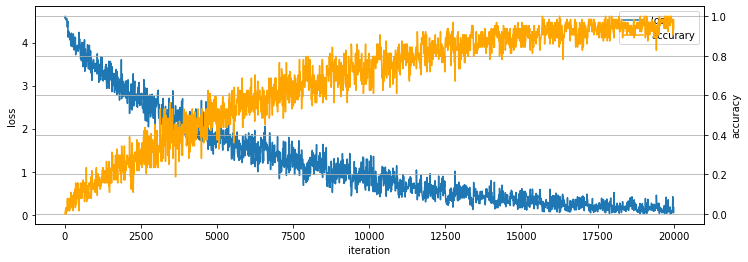

In [43]:
def plot_process():
    df = pd.read_csv(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH)
    
    fig, ax = plt.subplots(figsize=(12,4))
    ax2 = ax.twinx()
    lns1 = ax.plot(df['iteration'], df['loss'], label='loss')
    lns2 = ax2.plot(df['iteration'], df['accuracy'], color='orange', label='accurary')
    
    lns = lns1 + lns2
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs, loc=0)
    ax.set_ylabel('loss')
    ax.set_xlabel('iteration')
    ax2.set_ylabel('accuracy')
    plt.grid()
    plt.show()
    
plot_process()

## Test

--------------------
test function
--------------------
Files already downloaded and verified
50000 / 50000
 accuracy =  0.98338
ts / pred table
array([[485.,   0.,   1., ...,   0.,   0.,   0.],
       [  0., 495.,   0., ...,   0.,   0.,   0.],
       [  0.,   0., 492., ...,   0.,   0.,   0.],
       ...,
       [  0.,   0.,   0., ..., 497.,   1.,   0.],
       [  0.,   0.,   0., ...,   0., 489.,   0.],
       [  0.,   0.,   0., ...,   0.,   0., 495.]])


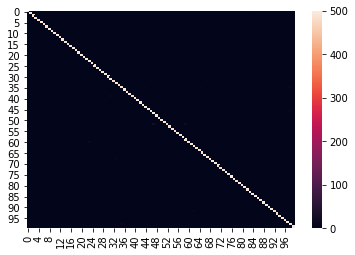

In [47]:
# test
def test():
    print('-'*20)
    print('test function')
    print('-'*20)
    model = VGG16().to(cfg.DEVICE)
    model.load_state_dict(torch.load(cfg.TEST.MODEL_PATH, map_location=torch.device(cfg.DEVICE)))
    model.eval()
    
    np.random.seed(0)
    ds = torchvision.datasets.CIFAR100(root=cfg.TRAIN.DATA_PATH, train=True, download=True, transform=None)
    Xs_data = torch.tensor(ds.data, dtype=torch.float).permute(0,3,1,2).to(cfg.DEVICE)
    Xs_data = Xs_data / 127.5 - 1
    ts_data = np.array(ds.targets)
    data_num = len(Xs_data)
    
    table = np.zeros([cfg.CLASS_NUM, cfg.CLASS_NUM])
    
    inds = np.arange(data_num)
    
    with torch.no_grad():
        for i in range(0, data_num, cfg.TEST.MINIBATCH):
            # get batch index
            mb_inds = inds[i: min(i+cfg.TEST.MINIBATCH, data_num)]
            Xs = Xs_data[mb_inds]
            ts = ts_data[mb_inds]
            
            # forward
            ys = F.softmax(model(Xs), dim=1).detach().cpu().numpy()
            ys = ys.argmax(axis = 1)
            
            for t,y in zip(ts, ys):
                table[t,y] += 1
                
            print('\r{} / {}'.format(mb_inds[-1] + 1, data_num), end='')
            
    accuracy = table[np.arange(cfg.CLASS_NUM), np.arange(cfg.CLASS_NUM)].sum() / table.sum()
    print('\n accuracy = ', accuracy)
    print('ts / pred table')
    pprint(table)
    sns.heatmap(table)
    
test()